# 0. Import libraries

In [5]:
# 0. Import

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co

from scipy.sparse import csr_matrix

In [2]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 4.5]
plt.rcParams["savefig.dpi"] = 500

# 1. Convert data
## 1.1. Convert Seurat rds into adata (anndata)
The scRNA-seq data must be in the anndata format.

In [10]:
adata = co.data_conversion.seurat_object_to_anndata('../mice_cdk8cdk19.rds', delete_tmp_file=True)

input file name: ../mice_cdk8cdk19.rds


Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

loading seurat object ...
  seurat object version is 4x
Processing an assay: RNA


KeyboardInterrupt: 

In [ ]:
primary_adata = adata["RNA"].copy()
primary_adata

In [ ]:
sparse_X = csr_matrix(primary_adata.layers['raw_count'], dtype=np.float32)
sparse_X = sparse_X.toarray()
sparse_X[:10, :10]


Execution halted


In [ ]:
primary_adata.obs['seurat_clusters'] = primary_adata.obs['seurat_clusters'].astype(str)

primary_adata.write_h5ad("cdk8.19_mouse_seurat_CO_notebook.h5ad")

# 1.2. Load data

In [3]:
# Load data.
adata = sc.read('cdk8.19_mouse_seurat_CO_notebook.h5ad')
# In this notebook, we use raw mRNA count as an input of Oracle object.
adata.X = adata.layers["raw_count"].copy()

In [8]:
# sparse_X = csr_matrix(adata.layers['raw_count'], dtype=np.float32)
# sparse_X = sparse_X.toarray()
# sparse_X[:10, :10]
#it's raw counts

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 6.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 5.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 2.]], dtype=float32)

In [6]:
# Try to load variable gene list
variable_gene_list = adata.var.variable_gene.values
    
# Select genes
adata = adata[:, variable_gene_list]

In [8]:
adata.obs['cell_type_condition'] = adata.obs['predicted.CellTypes'].str.cat(adata.obs['condition'], sep="_")

... storing 'cell_type_condition' as categorical


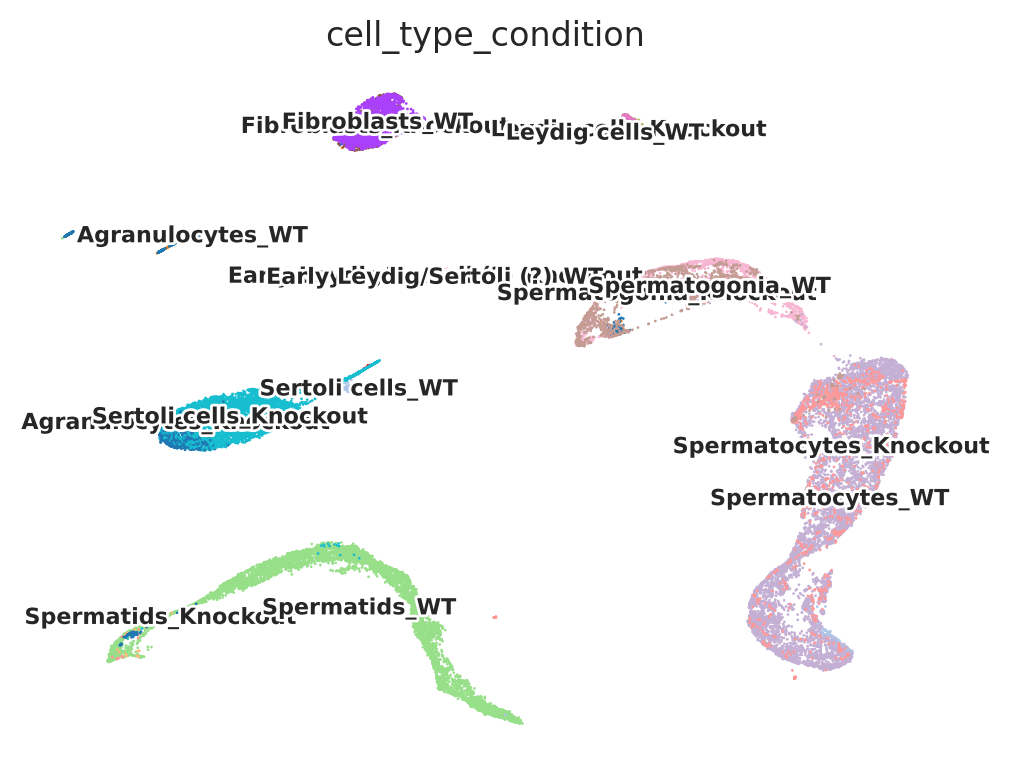

In [9]:
# Data visualization
sc.pl.embedding(adata,
                basis = 'X_umap',
                color = ['cell_type_condition'],
                frameon = False,
                legend_loc = 'on data',
                legend_fontoutline = 2,
                legend_fontsize = 8
               )

In [10]:
# Random down sampling
random_sampling_size = 20000
if adata.shape[0] > random_sampling_size:
    cells_random = np.random.choice(adata.obs.index.values, random_sampling_size, replace=False)
    
    adata = adata[cells_random, :]

In [11]:
# Check data shape again

print("Number of cell : ", adata.shape[0])
print("Number of gene : ", adata.shape[1])

Number of cell :  20000
Number of gene :  3500


## 1.2. Load base-GRN data. 

In [94]:
# Load TF info which was made from mouse cell atlas dataset.
# base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN = pd.read_csv('base_GRN.csv', index_col=0)
# Check data
base_GRN.head()

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100050979_100052296   4930430F08Rik            0.0         0.0   
1  chr10_101006922_101007748         SNORA17            0.0         0.0   
2  chr10_101144061_101145000          Mgat4c            0.0         0.0   
3    chr10_10148873_10149183   9130014G24Rik            0.0         0.0   
4    chr10_10149425_10149815   9130014G24Rik            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     1.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1095 columns]

In [75]:
# base_GRN.to_csv('base_GRN.csv')

# 2. Make Oracle object

We will use an Oracle object during the data preprocessing and GRN inference steps. Using its internal functions, the Oracle object computes and stores all of the necessary information for these calculations. To begin, we will instantiate a new Oracle object and input our gene expression data (anndata) and TF info (base GRN).

In [13]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

In [14]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'percent.hb', 'scrublet.sc', 'DoubletFinder.sc', 'DoubletFinder.cl', 'DoubletFinder.cl.conf', 'AmbDecontX', 'nCount_RNAorig', 'nFeature_RNAorig', 'nCount_RNAsoupX', 'nFeature_RNAsoupX', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'predicted.CellTypes.score', 'predicted.CellTypes', 'samples', 'condition', 'original_cells', 'cells_with_cluster', 'nCount_prediction.score.CellTypes', 'nFeature_prediction.score.CellTypes', 'joined_clust', 'active_ident', 'cell_type_condition']
Dimensional reduction:  ['X_harmony', 'X_pca', 'X_umap']


In [18]:
# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="cell_type_condition",
                                   embedding_name="X_umap")

## 2.2. Load base-GRN data into oracle object

In [19]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

# 3. KNN imputation

## 3.1. PCA

In [20]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.20.0
    n_cells: 20000
    n_genes: 3500
    cluster_name: cell_type_condition
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 21256 genes
    n_regulatory_in_TFdict: 1093 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 149 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2501 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

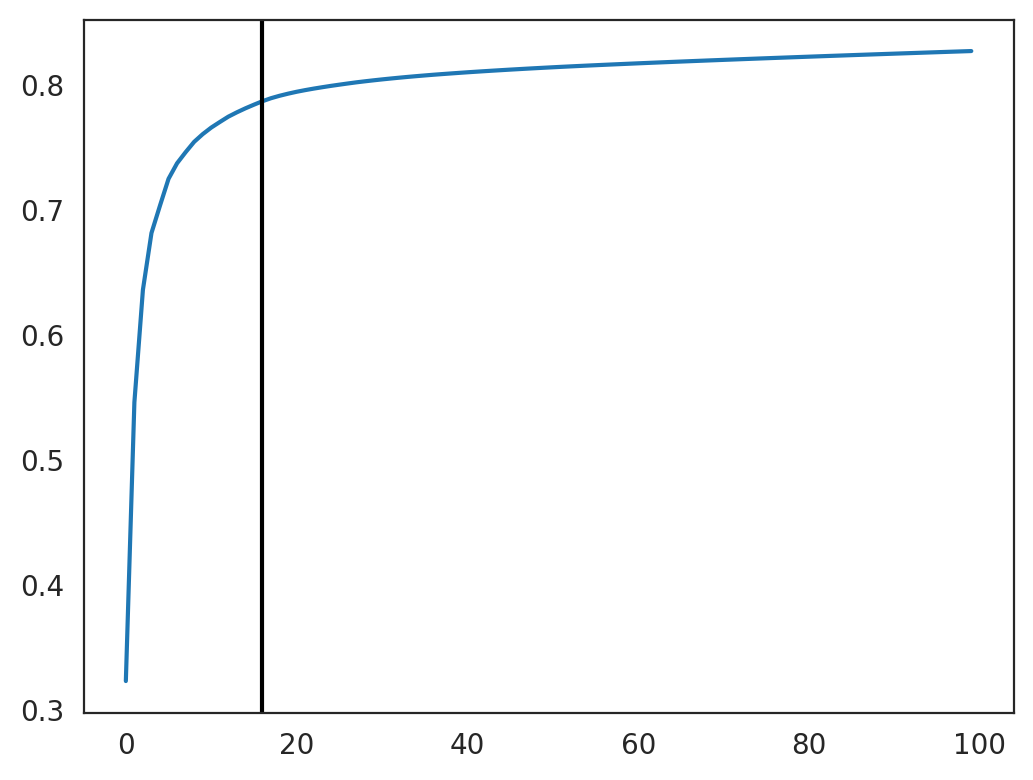

16


In [21]:
from threadpoolctl import threadpool_limits

# Limit threads to 4
with threadpool_limits(limits=10):
    # Perform PCA
    oracle.perform_PCA()
    
    # Select important PCs
    plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
    n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
    plt.axvline(n_comps, c="k")
    plt.show()
    print(n_comps)
    n_comps = min(n_comps, 50)
    pass

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [22]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :20000


In [23]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :500


In [24]:
# Limit threads to 4
with threadpool_limits(limits=4):
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)
    pass

# 4. Save and Load.

In [25]:
# Save oracle object.
oracle.to_hdf5("cdk8.19_mouse_seurat_CO_notebook.celloracle.oracle")

In [ ]:
# Load file.
oracle = co.load_hdf5("cdk8.19_mouse_seurat_CO_notebook.celloracle.oracle")

In [26]:
oracle.adata

AnnData object with n_obs × n_vars = 20000 × 3500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'percent.hb', 'scrublet.sc', 'DoubletFinder.sc', 'DoubletFinder.cl', 'DoubletFinder.cl.conf', 'AmbDecontX', 'nCount_RNAorig', 'nFeature_RNAorig', 'nCount_RNAsoupX', 'nFeature_RNAsoupX', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'predicted.CellTypes.score', 'predicted.CellTypes', 'samples', 'condition', 'original_cells', 'cells_with_cluster', 'nCount_prediction.score.CellTypes', 'nFeature_prediction.score.CellTypes', 'joined_clust', 'active_ident', 'cell_type_condition'
    var: 'variable_gene', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'active_ident_colors', 'joined_clust_colors', 'cell_type_condition_colors', 'log1p'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'raw_count', 'normalized_count', 'imputed_count'

# 5. GRN calculation

In [28]:
%%time

links = oracle.get_links(cluster_name_for_GRN_unit="cell_type_condition", alpha=10,
                         verbose_level=10, test_mode=False, n_jobs=10)

  0%|          | 0/16 [00:00<?, ?it/s]

Inferring GRN for Agranulocytes_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Agranulocytes_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Early Leydig/Sertoli (?)_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Early Leydig/Sertoli (?)_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Fibroblasts_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Fibroblasts_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Leydig cells_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Leydig cells_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Sertoli cells_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Sertoli cells_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Spermatids_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Spermatids_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Spermatocytes_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Spermatocytes_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Spermatogonia_Knockout...


  0%|          | 0/2501 [00:00<?, ?it/s]

Inferring GRN for Spermatogonia_WT...


  0%|          | 0/2501 [00:00<?, ?it/s]

CPU times: user 1h 31min 15s, sys: 3min 8s, total: 1h 34min 23s
Wall time: 1h 49min 33s


In [29]:
# Save Links object.
links.to_hdf5(file_path="cdk8.19_mouse_seurat_CO_notebook.celloracle.links")

# 6. Network preprocessing

## 6.1. Filter network edges 

In [31]:
# links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
# I did:
links.filter_links(p=0.05, weight="coef_abs", threshold_number=2000)

## 6.2. Degree distribution 

In [32]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Agranulocytes_Knockout


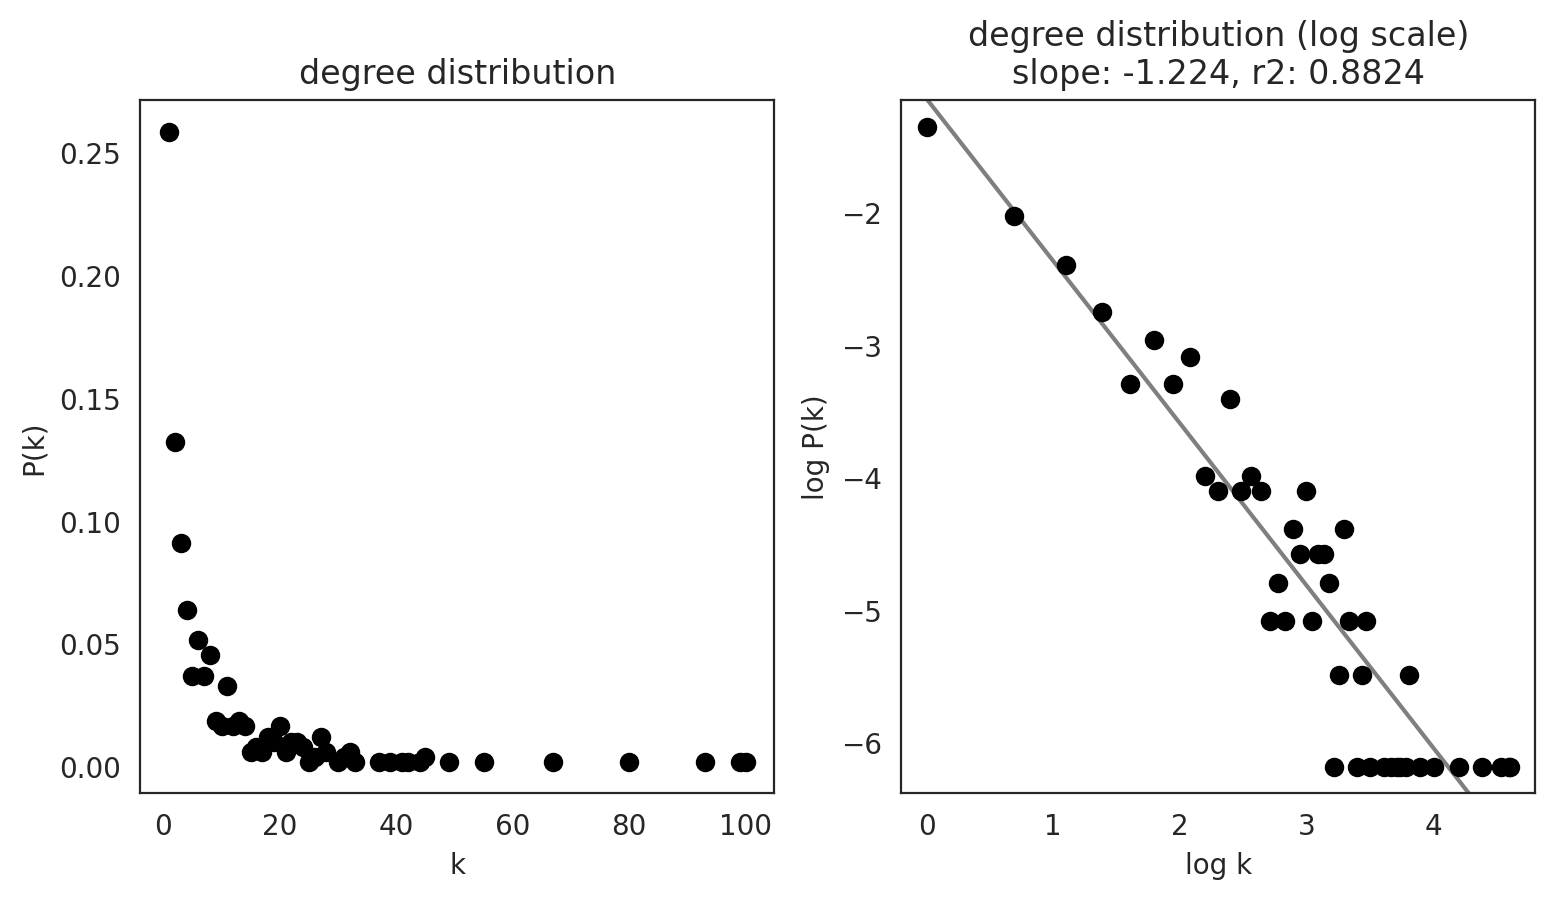

Agranulocytes_WT


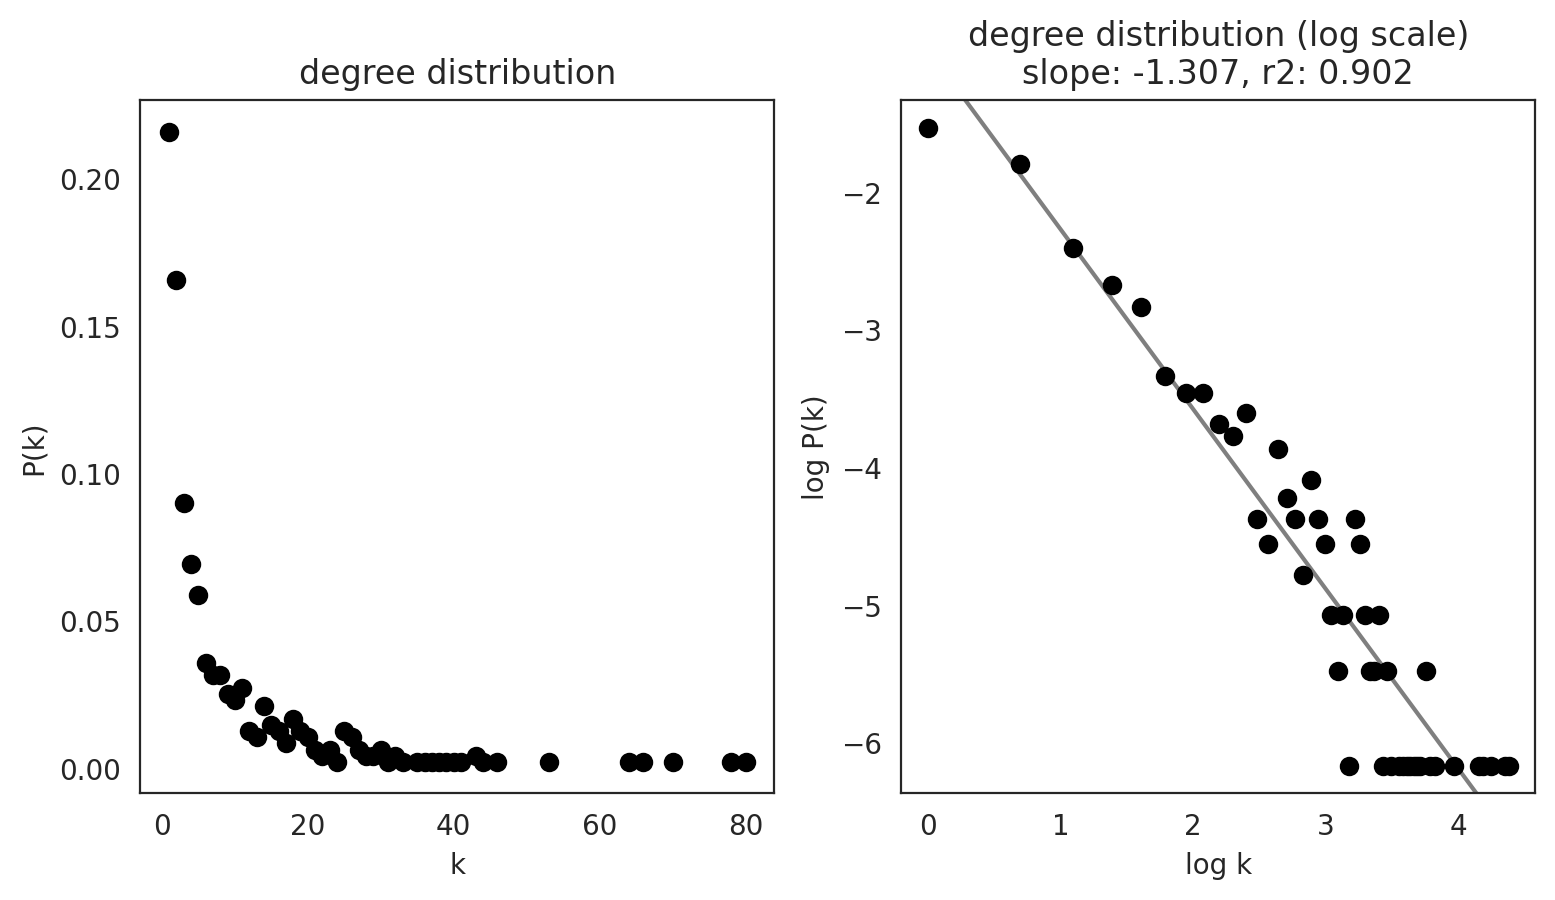

Early Leydig/Sertoli (?)_Knockout


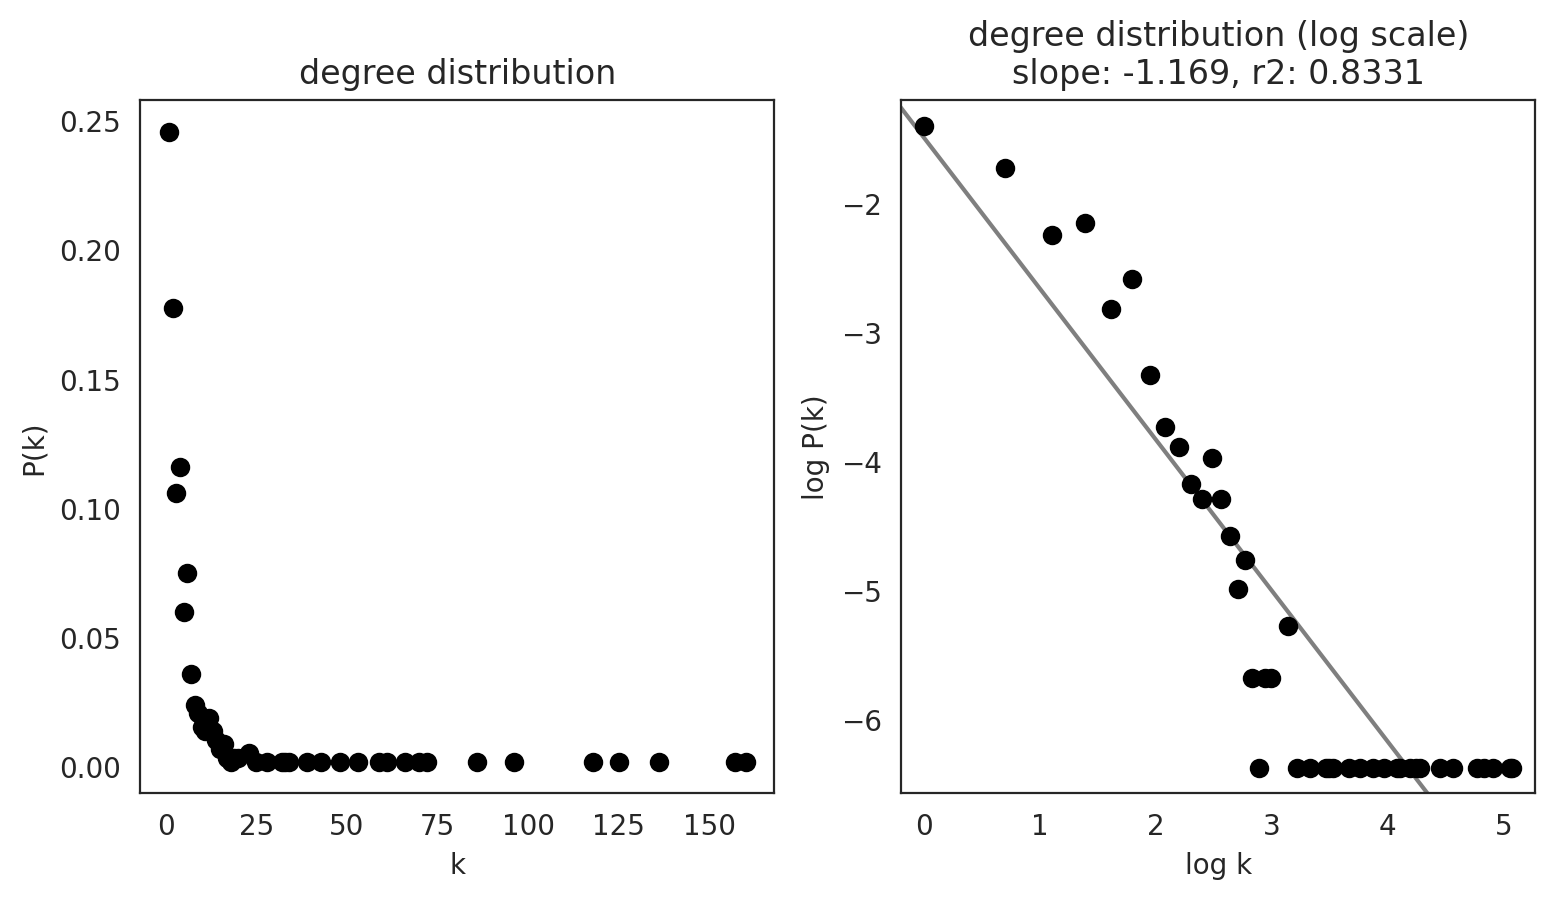

Early Leydig/Sertoli (?)_WT


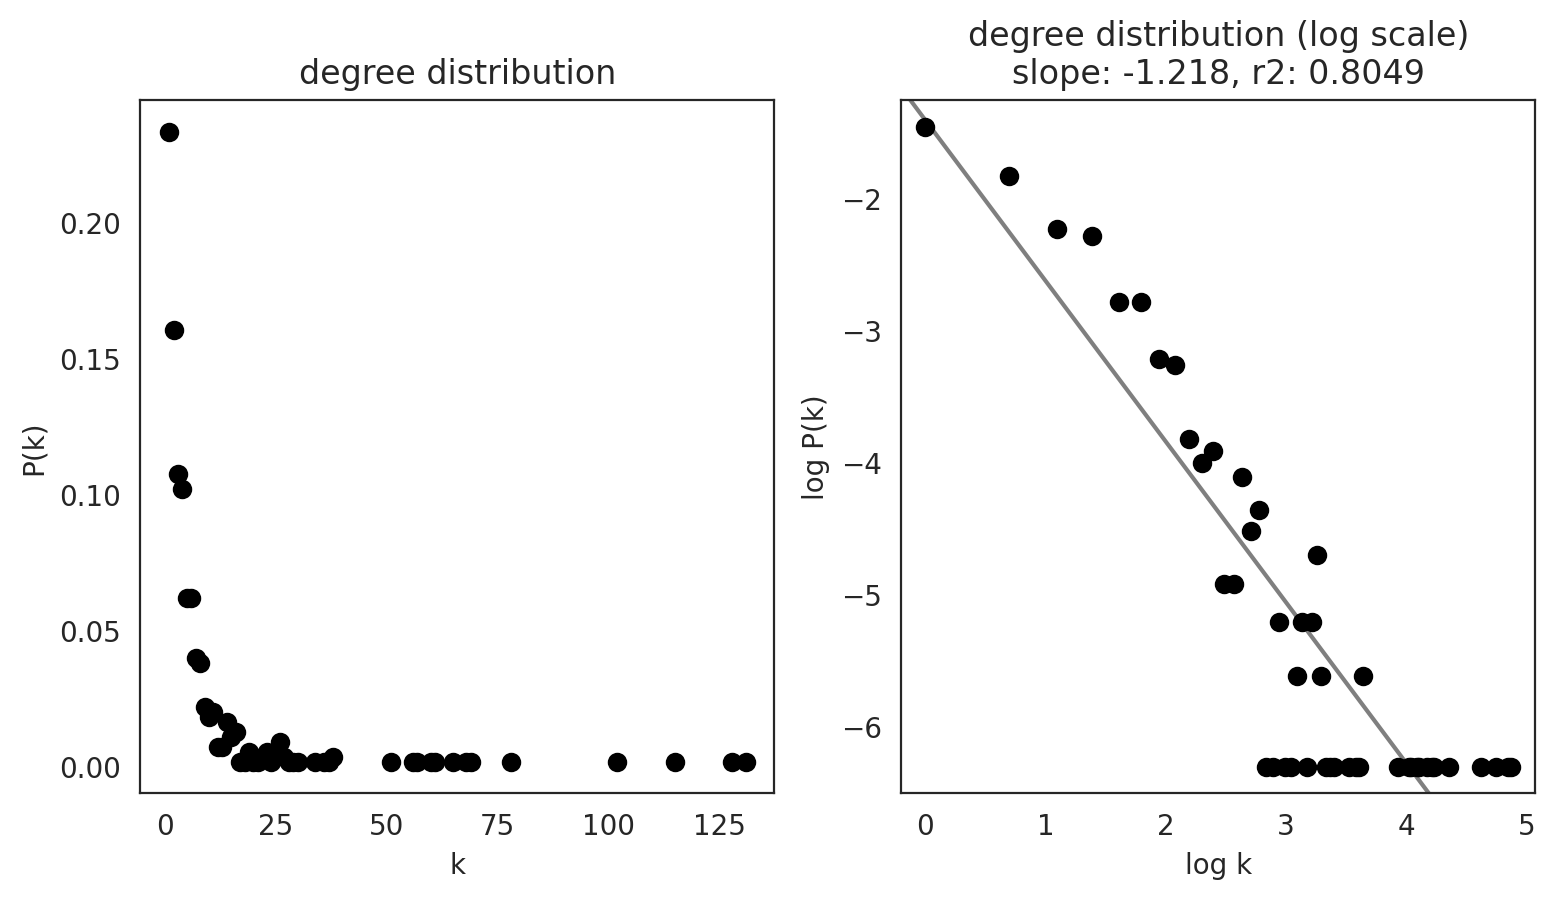

Fibroblasts_Knockout


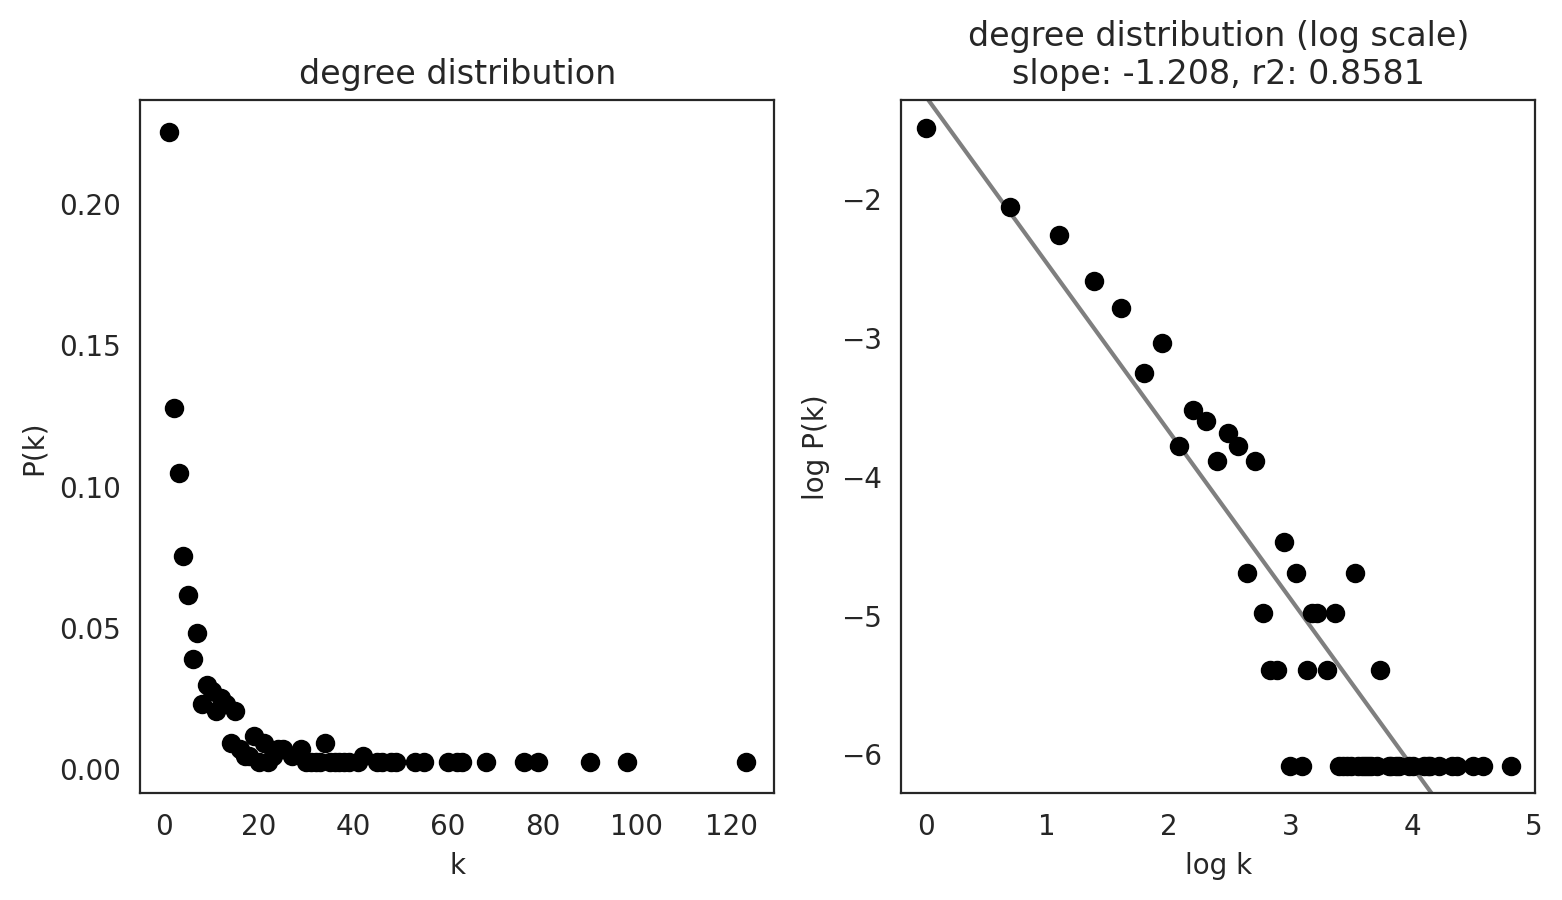

Fibroblasts_WT


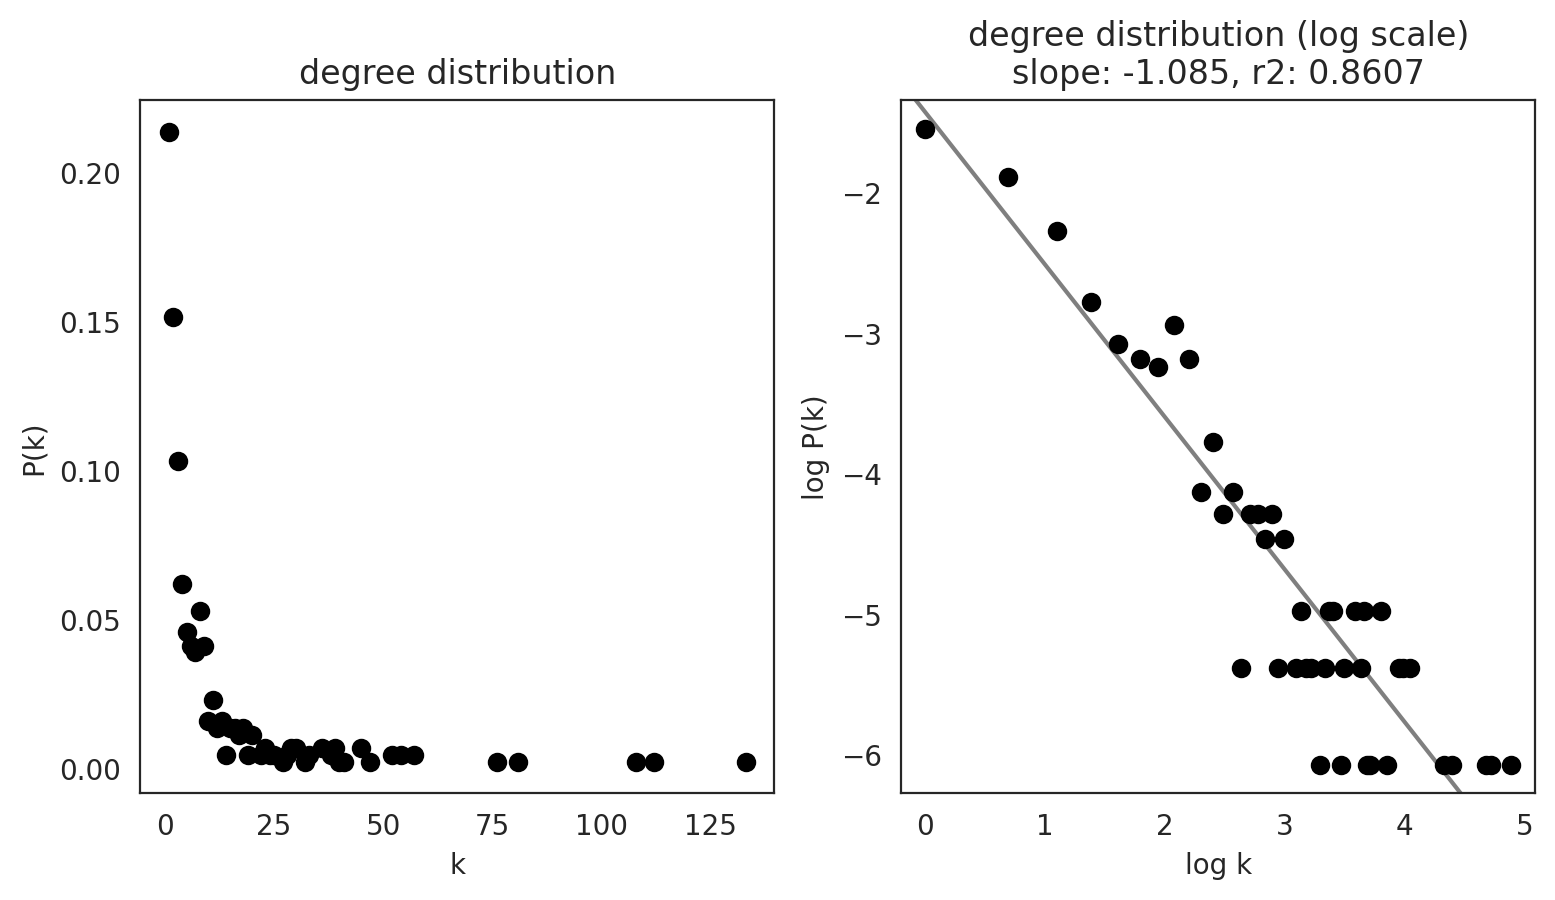

Leydig cells_Knockout


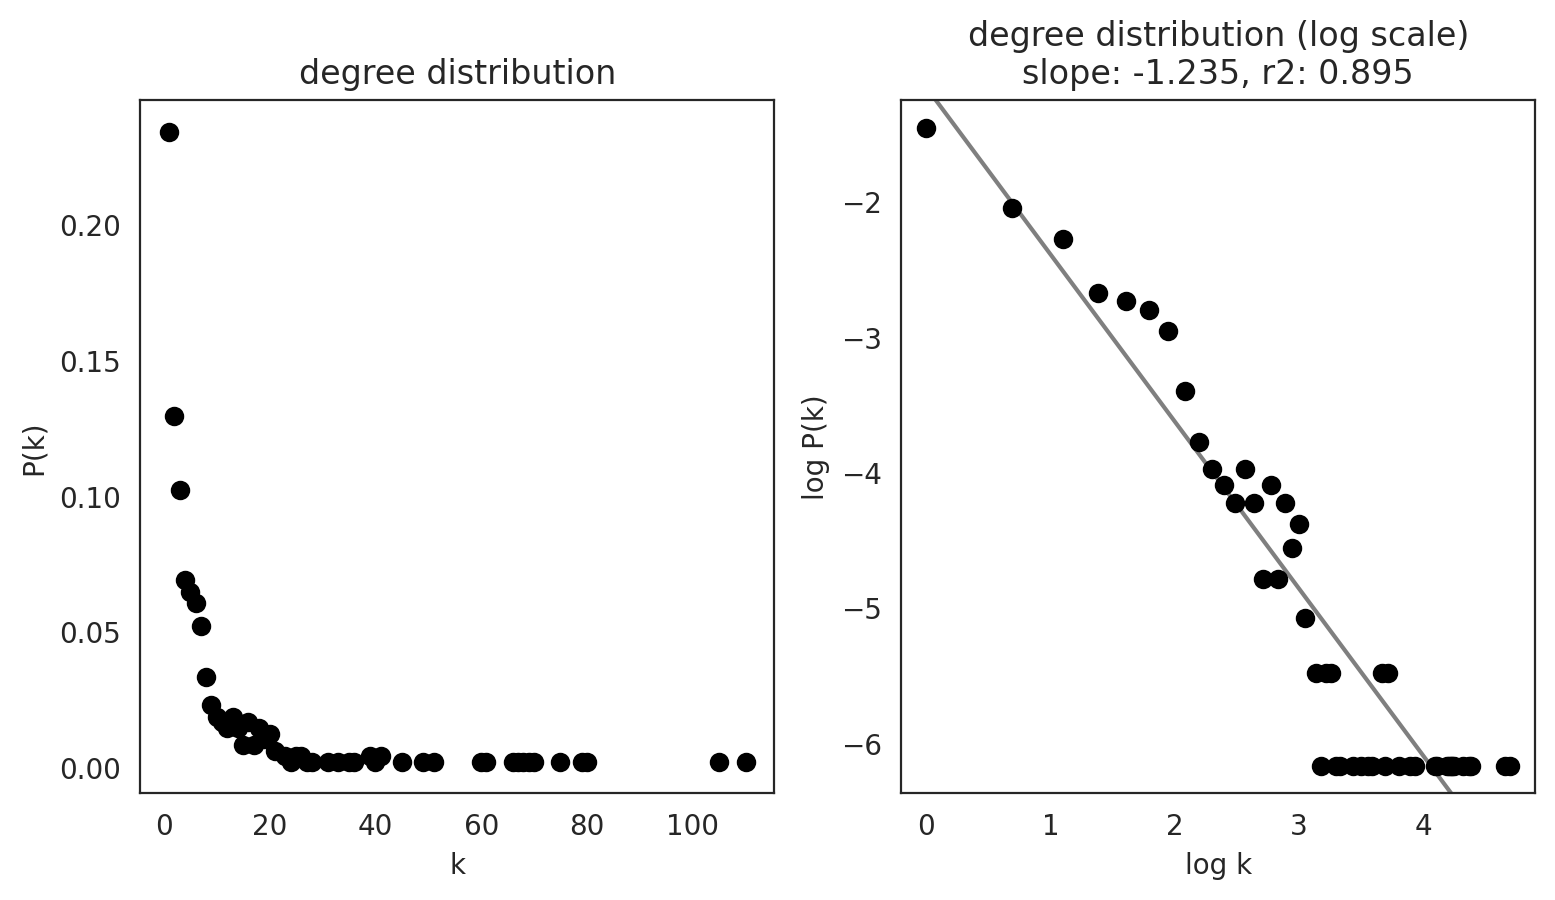

Leydig cells_WT


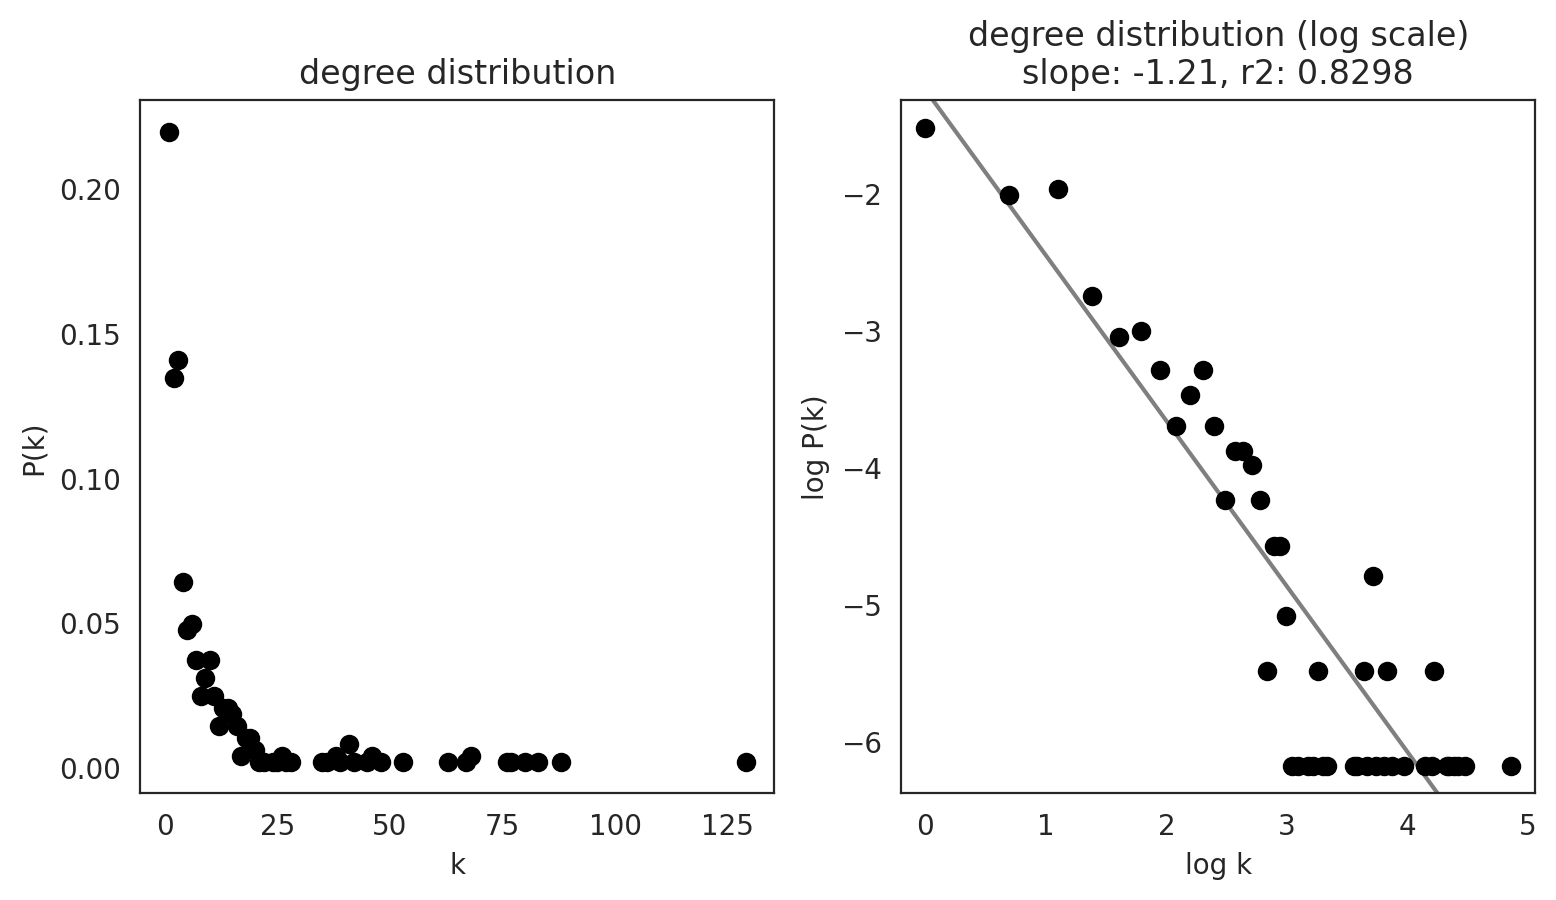

Sertoli cells_Knockout


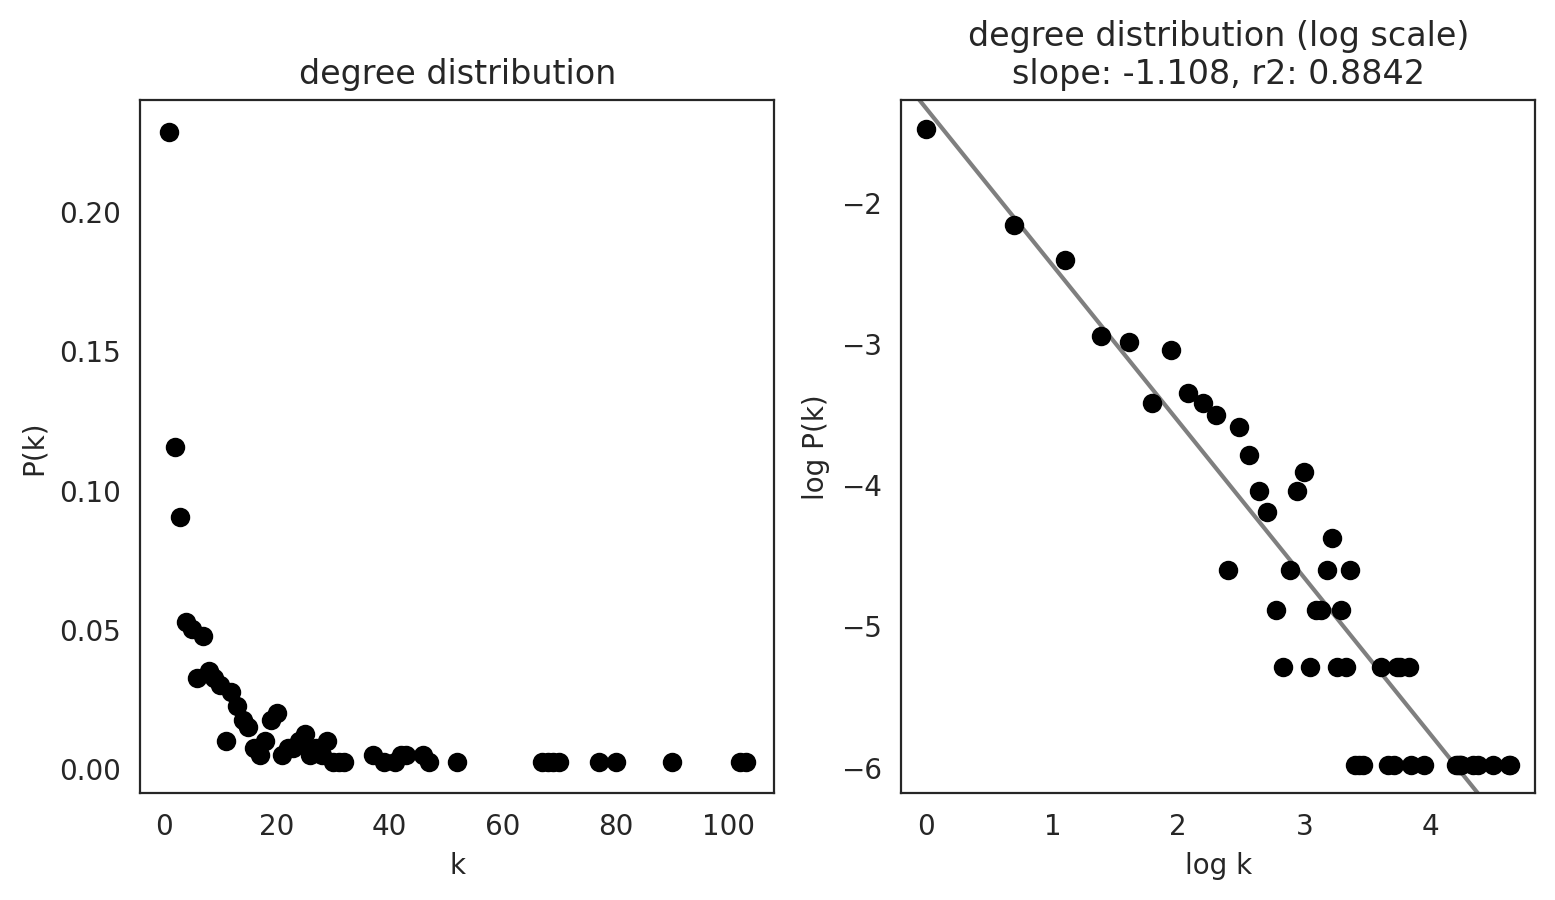

Sertoli cells_WT


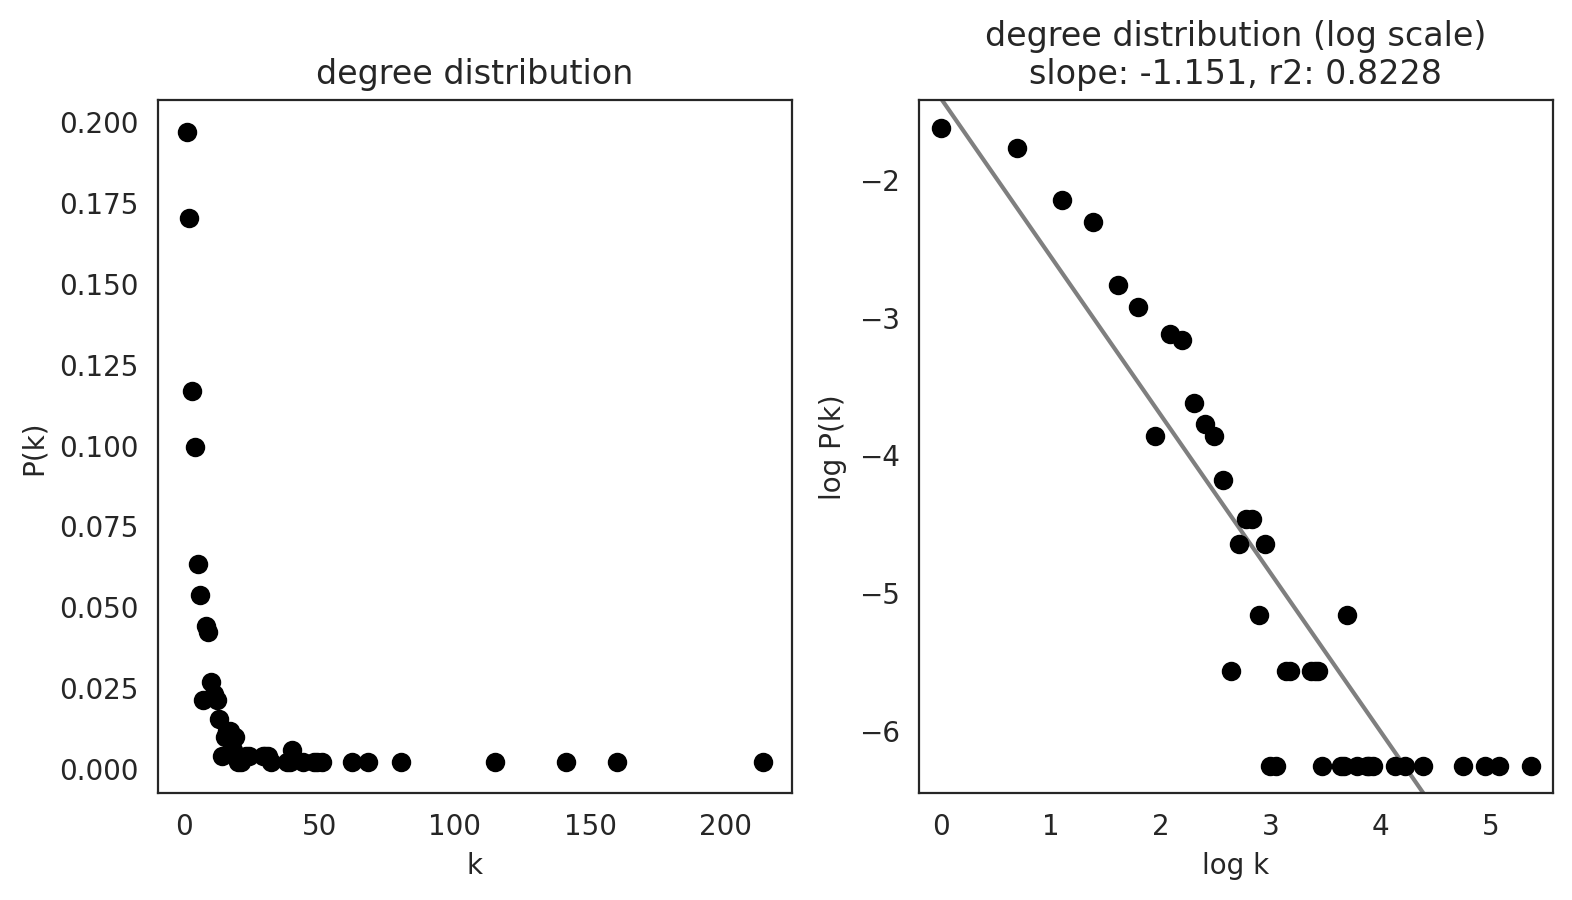

Spermatids_Knockout


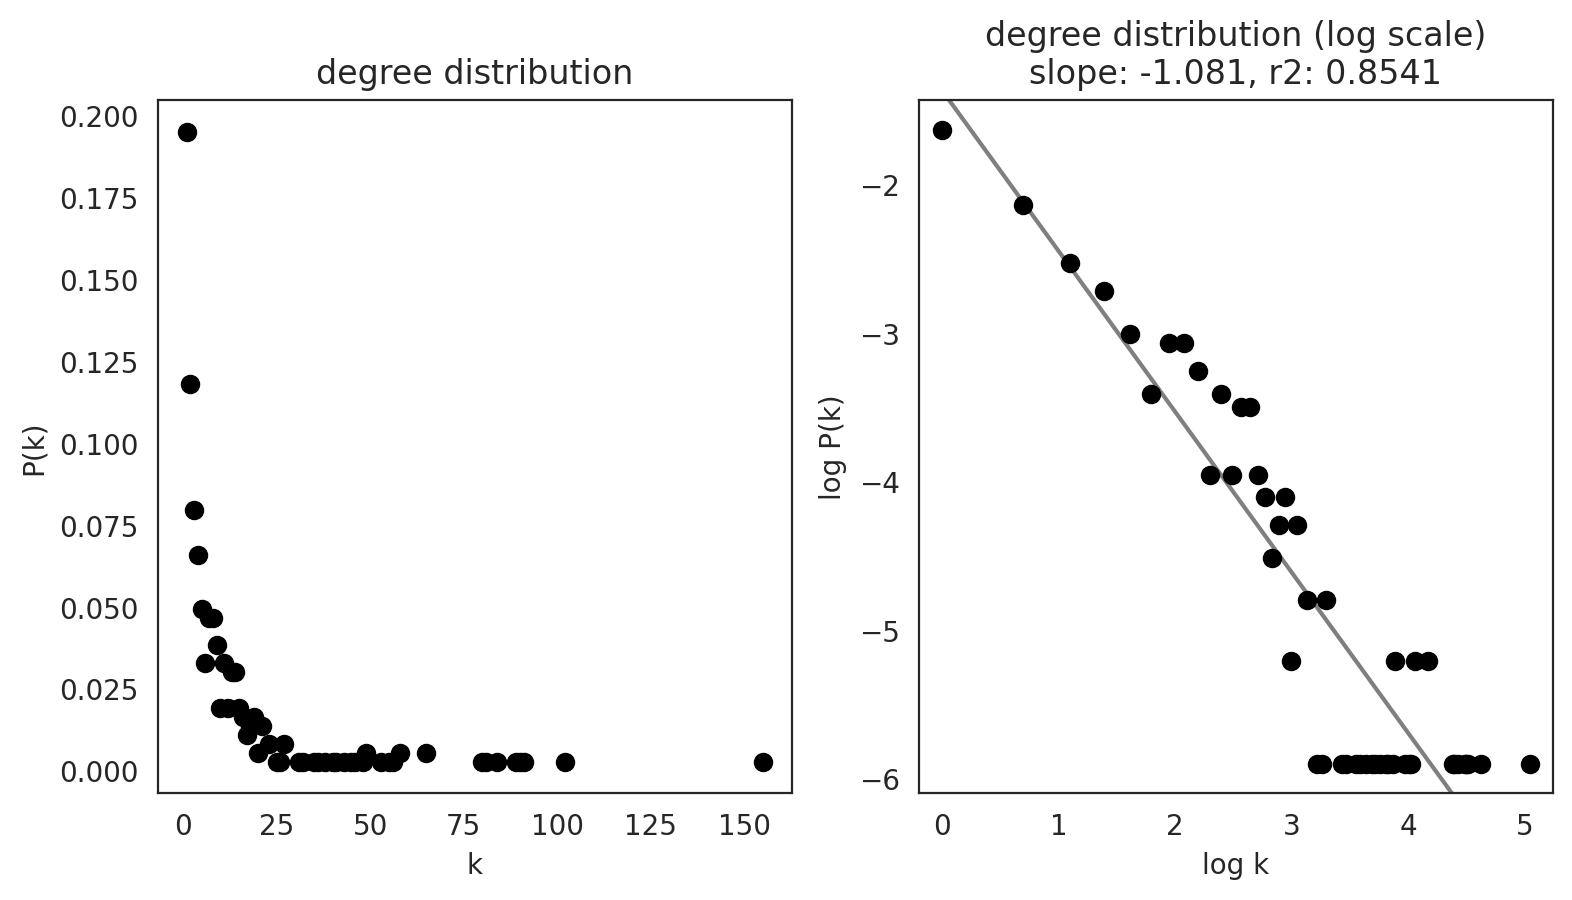

Spermatids_WT


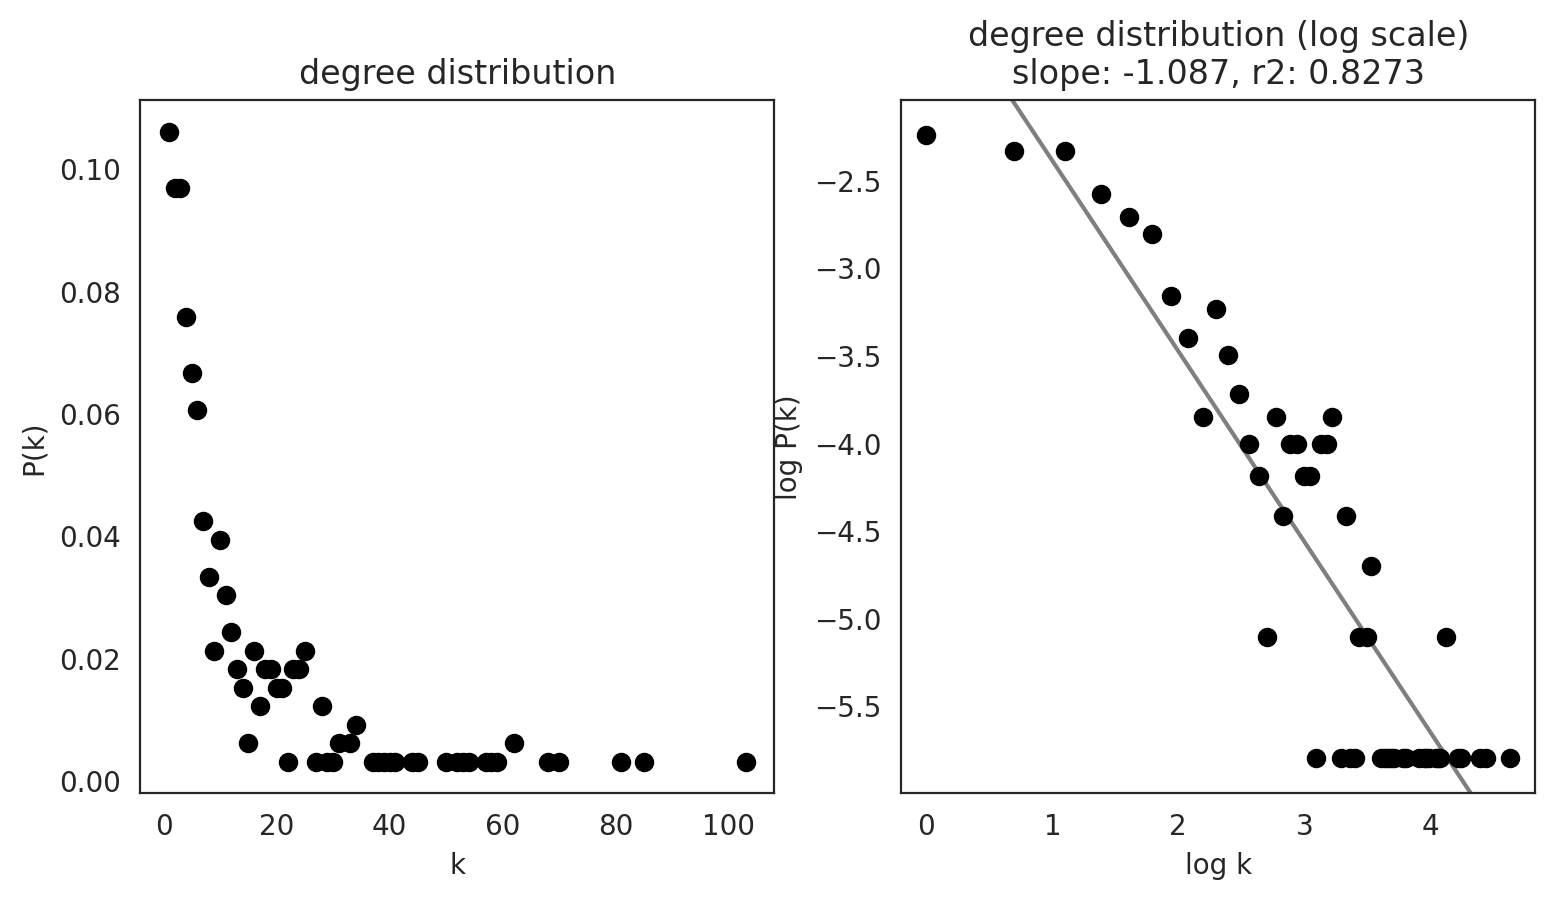

Spermatocytes_Knockout


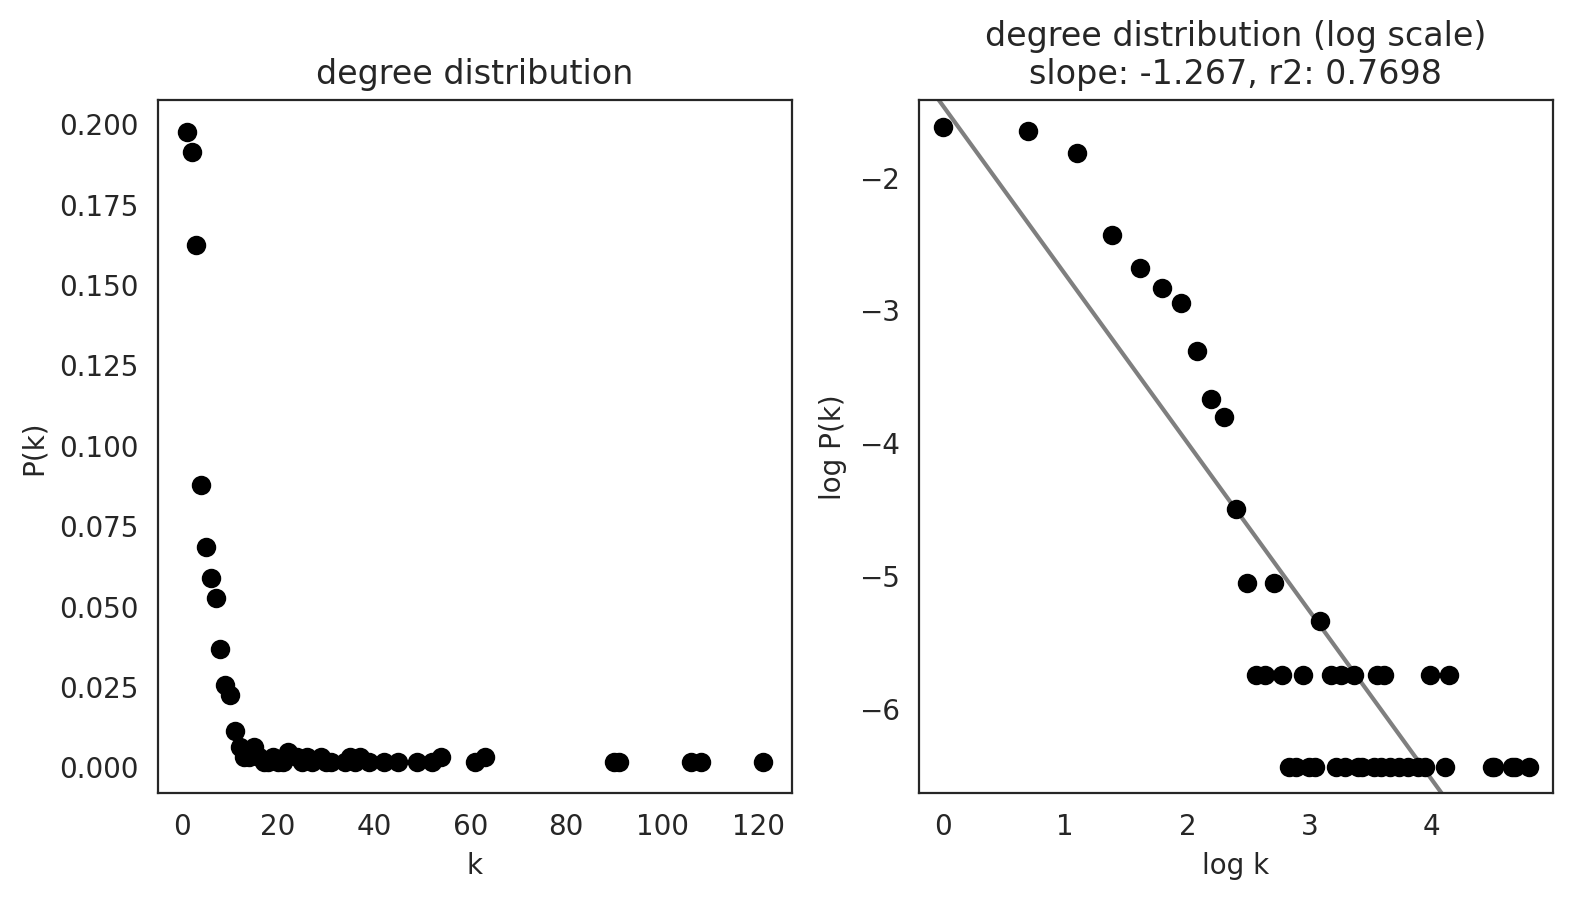

Spermatocytes_WT


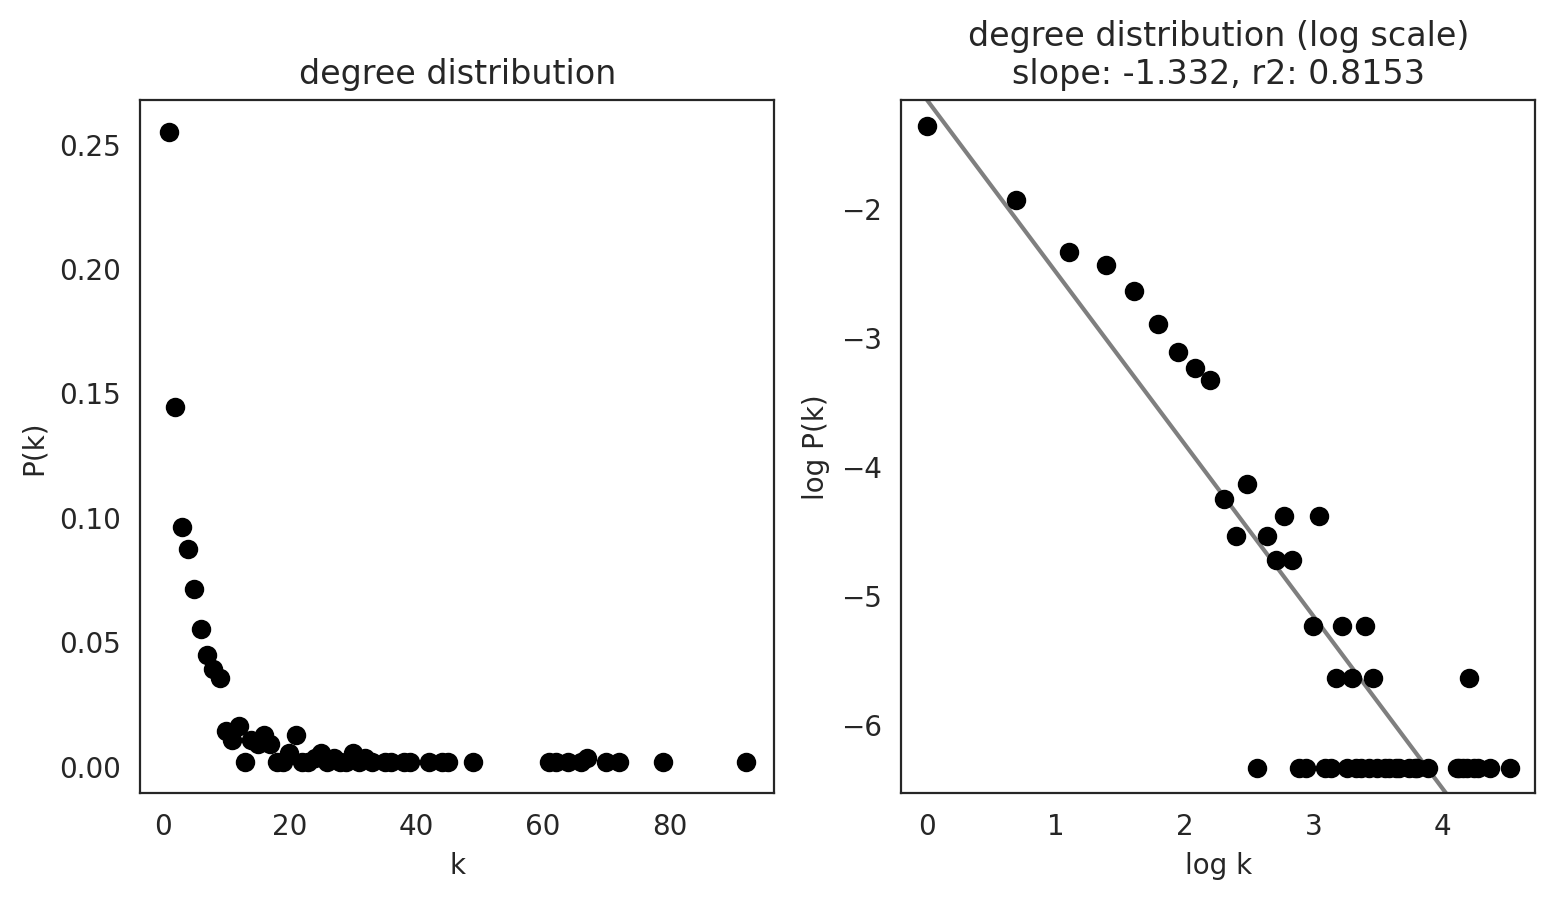

Spermatogonia_Knockout


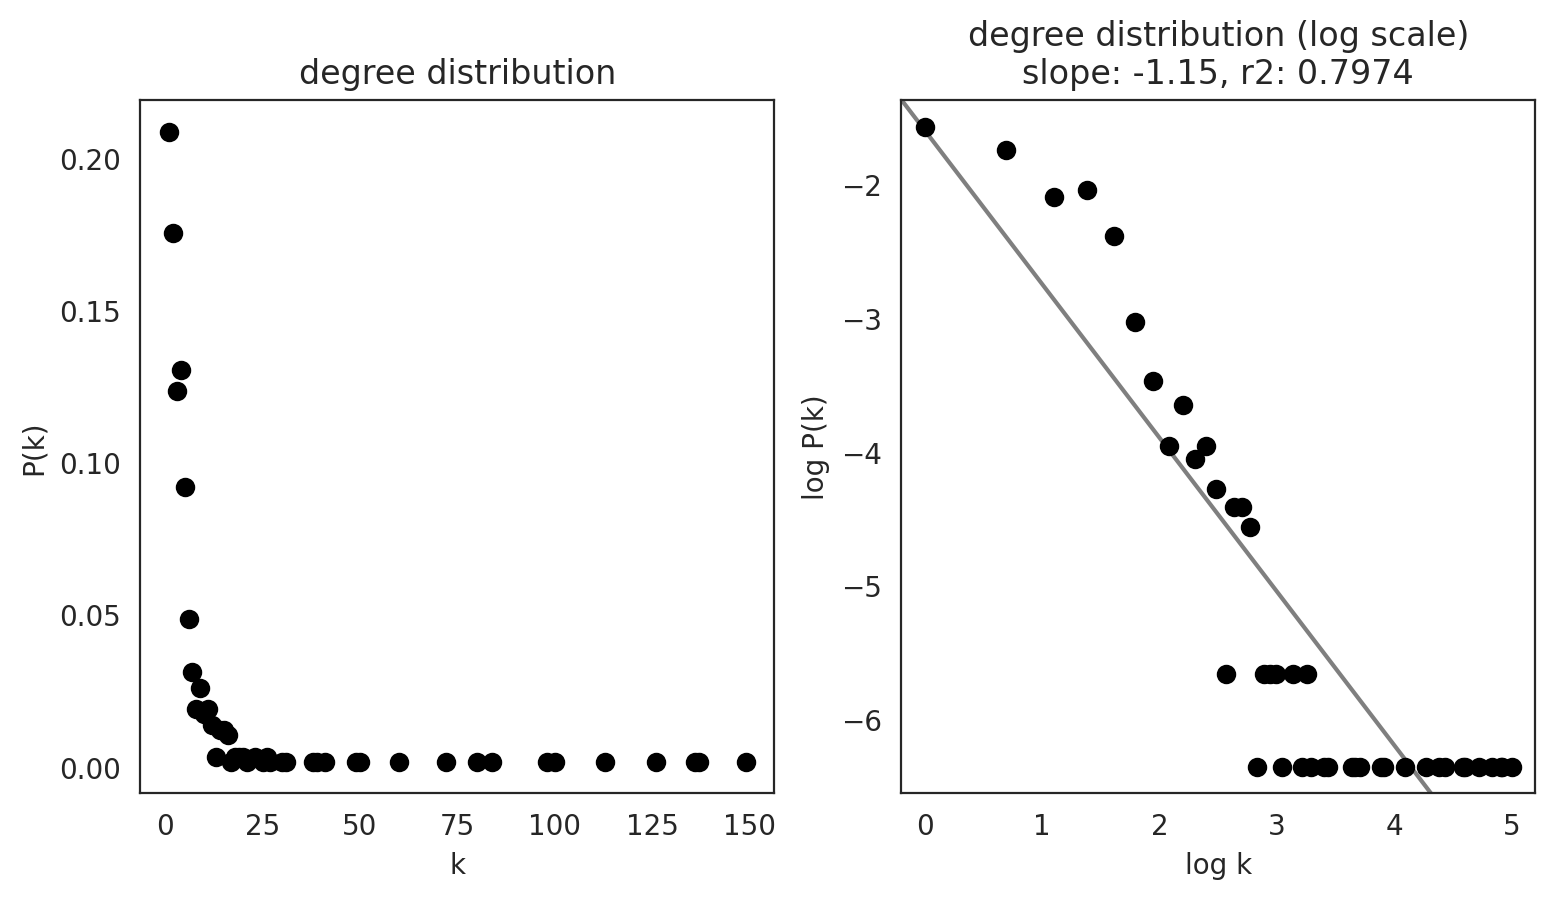

Spermatogonia_WT


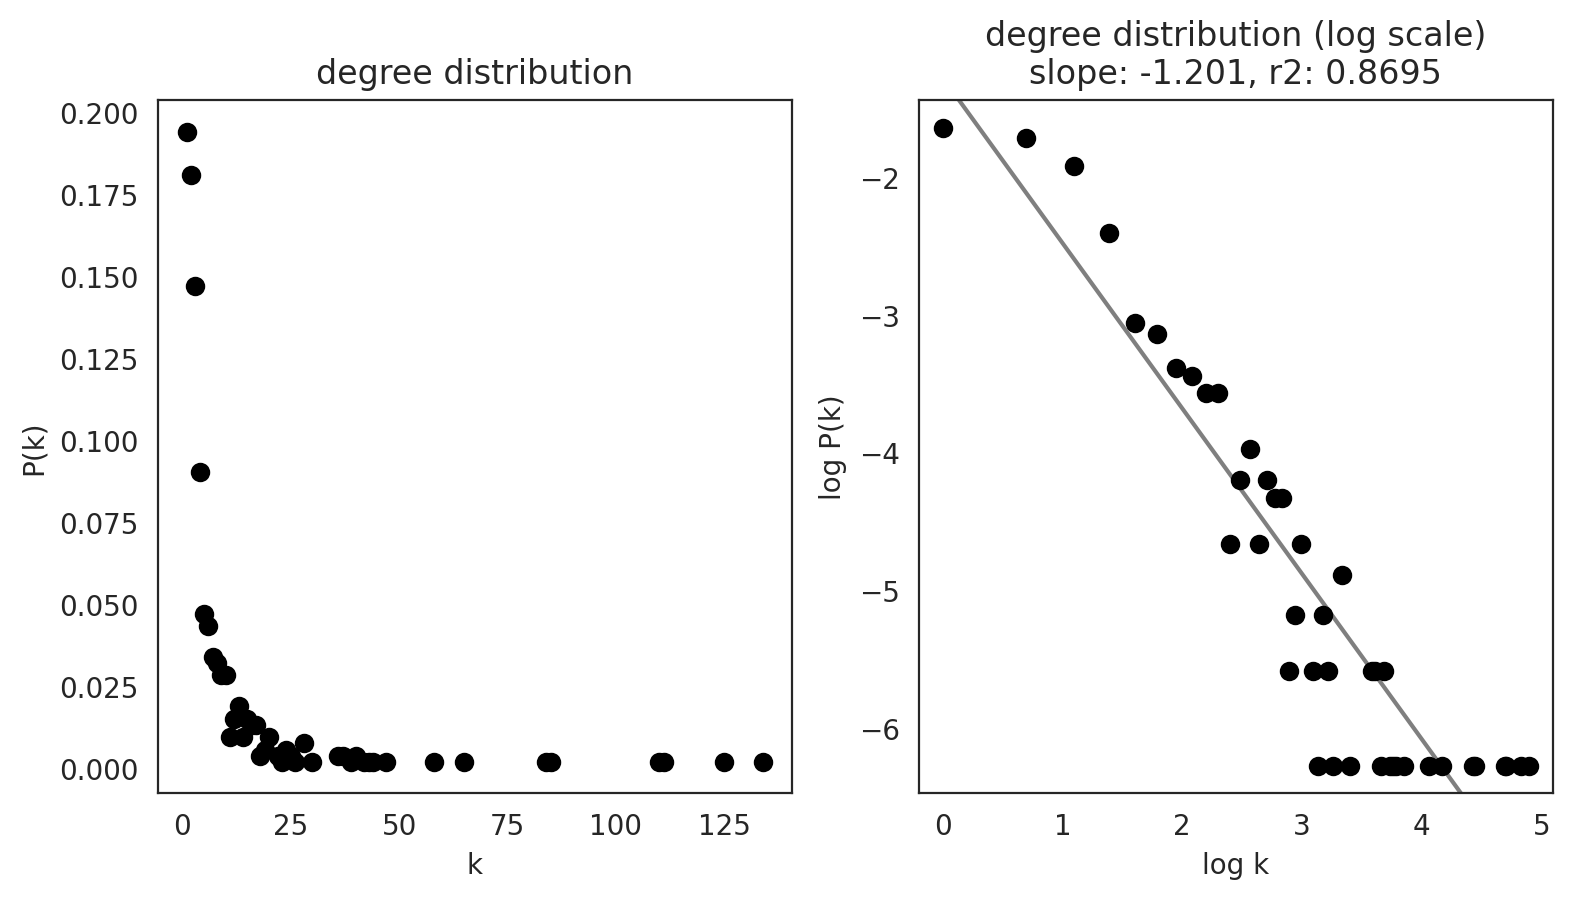

In [33]:
links.plot_degree_distributions(plot_model=True)

## 6.3. Calculate netowrk score

In [34]:
# Calculate network scores. 
links.get_network_score()

The score is stored as a attribute `merged_score`.

In [35]:
links.merged_score

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
Nr2c2           24               0.049689          0              0.000000   
Wfdc10           2               0.004141          2              0.004141   
Wt1            100               0.207039          3              0.006211   
Defb19          18               0.037267         18              0.037267   
Aard            20               0.041408         20              0.041408   
...            ...                    ...        ...                   ...   
Asz1             1               0.001887          1              0.001887   
Them4            1               0.001887          1              0.001887   
Osr2             1               0.001887          0              0.000000   
Taf2             1               0.001887          1              0.001887   
Brca2            1               0.001887          1              0.001887   

        degree_out  degree_centrality_out  betweenness_centrality  \
Nr2c2           24               0.049689                     0.0   
Wfdc10           0               0.000000                     0.0   
Wt1             97               0.200828                   208.0   
Defb19           0               0.000000                     0.0   
Aard             0               0.000000                     0.0   
...            ...                    ...                     ...   
Asz1             0               0.000000                     0.0   
Them4            0               0.000000                     0.0   
Osr2             1               0.001887                     0.0   
Taf2             0               0.000000                     0.0   
Brca2            0               0.000000                     0.0   

        eigenvector_centrality                 cluster  
Nr2c2                 0.600939  Agranulocytes_Knockout  
Wfdc10                0.477329  Agranulocytes_Knockout  
Wt1                   1.000000  Agranulocytes_Knockout  
Defb19                0.738450  Agranulocytes_Knockout  
Aard                  0.639432  Agranulocytes_Knockout  
...                        ...                     ...  
Asz1                  0.002869        Spermatogonia_WT  
Them4                 0.002400        Spermatogonia_WT  
Osr2                  0.000429        Spermatogonia_WT  
Taf2                  0.003651        Spermatogonia_WT  
Brca2                 0.004339        Spermatogonia_WT  

[7841 rows x 9 columns]

## 6.4. Save

Save processed GRNs. We will use this file during the in in silico TF perturbation analysis.

In [36]:
# Save Links object.
links.to_hdf5(file_path="cdk8.19_mouse_seurat_CO_notebook.celloracle.links")

In [3]:
# You can load files with the following command.
links = co.load_hdf5(file_path="cdk8.19_mouse_seurat_CO_notebook.celloracle.links")


# 7. Network analysis; Network score for each gene
The `Links` class has many functions to visualize network score.
See the web documentation to learn more about these functions.

## 7.1. Network score in each cluster


In [6]:
# Check cluster name
links.cluster

['Agranulocytes_Knockout',
 'Agranulocytes_WT',
 'Early Leydig/Sertoli (?)_Knockout',
 'Early Leydig/Sertoli (?)_WT',
 'Fibroblasts_Knockout',
 'Fibroblasts_WT',
 'Leydig cells_Knockout',
 'Leydig cells_WT',
 'Sertoli cells_Knockout',
 'Sertoli cells_WT',
 'Spermatids_Knockout',
 'Spermatids_WT',
 'Spermatocytes_Knockout',
 'Spermatocytes_WT',
 'Spermatogonia_Knockout',
 'Spermatogonia_WT']

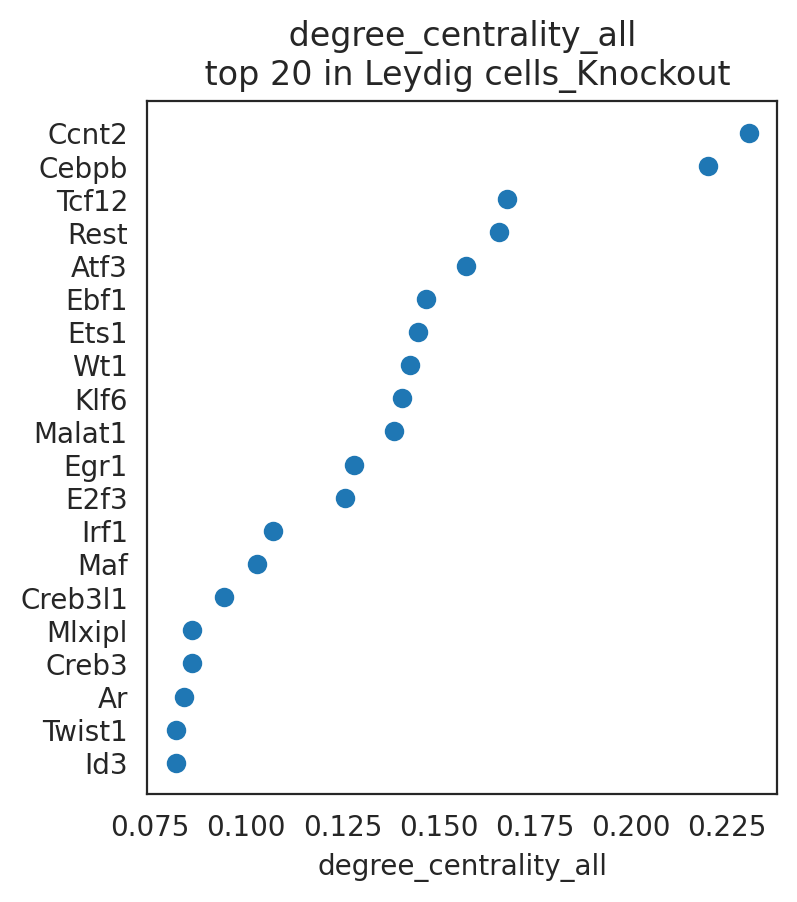

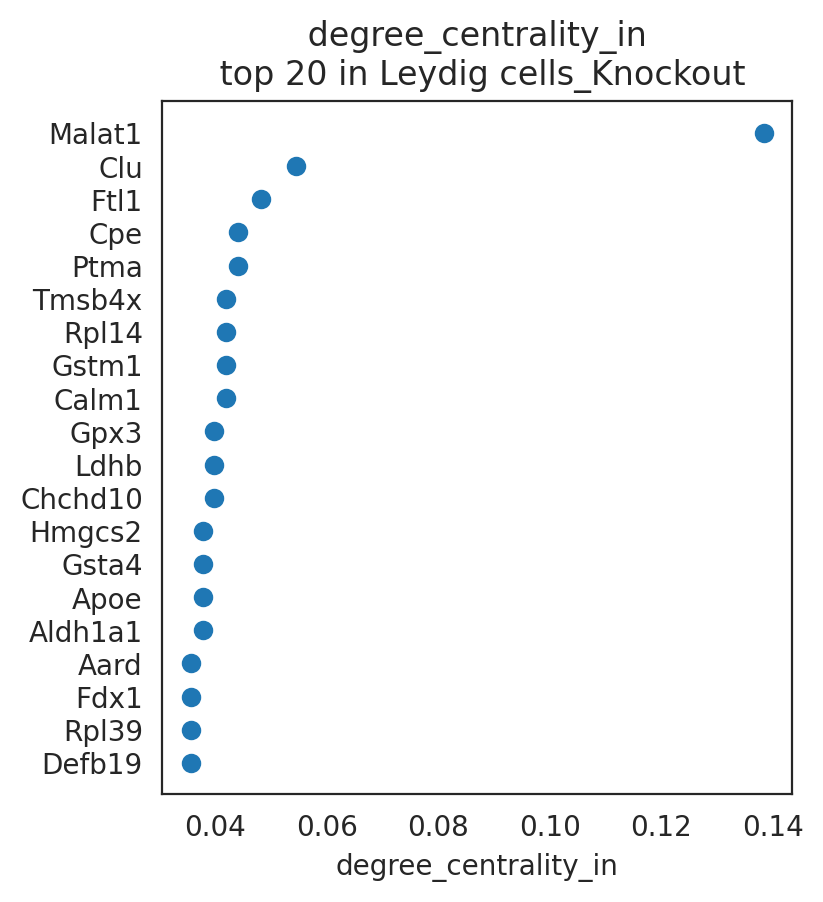

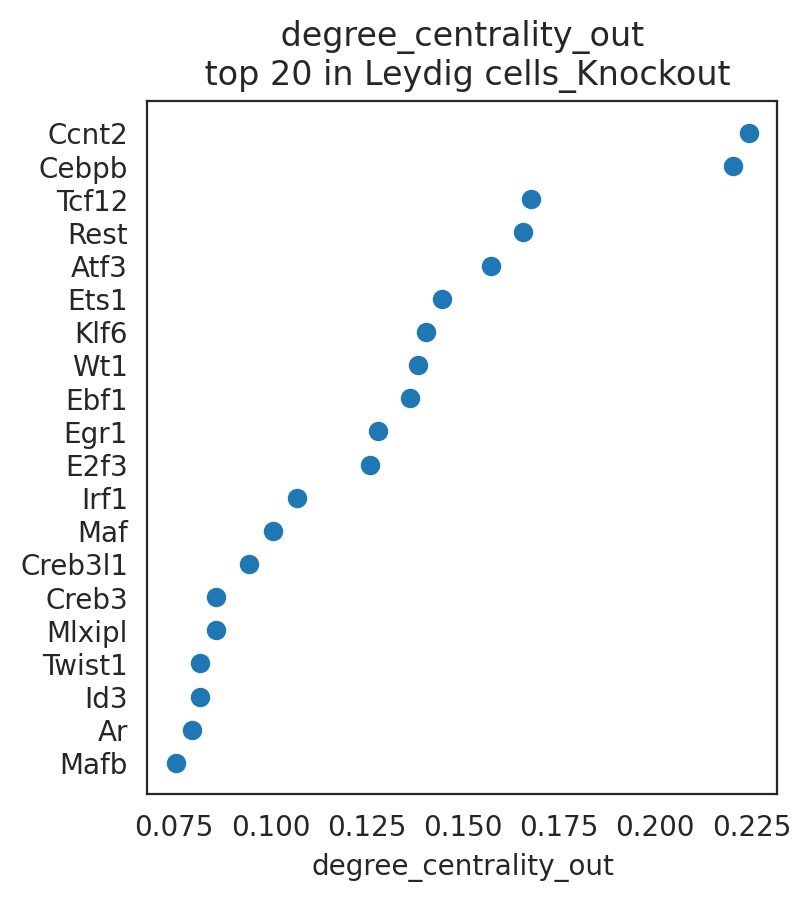

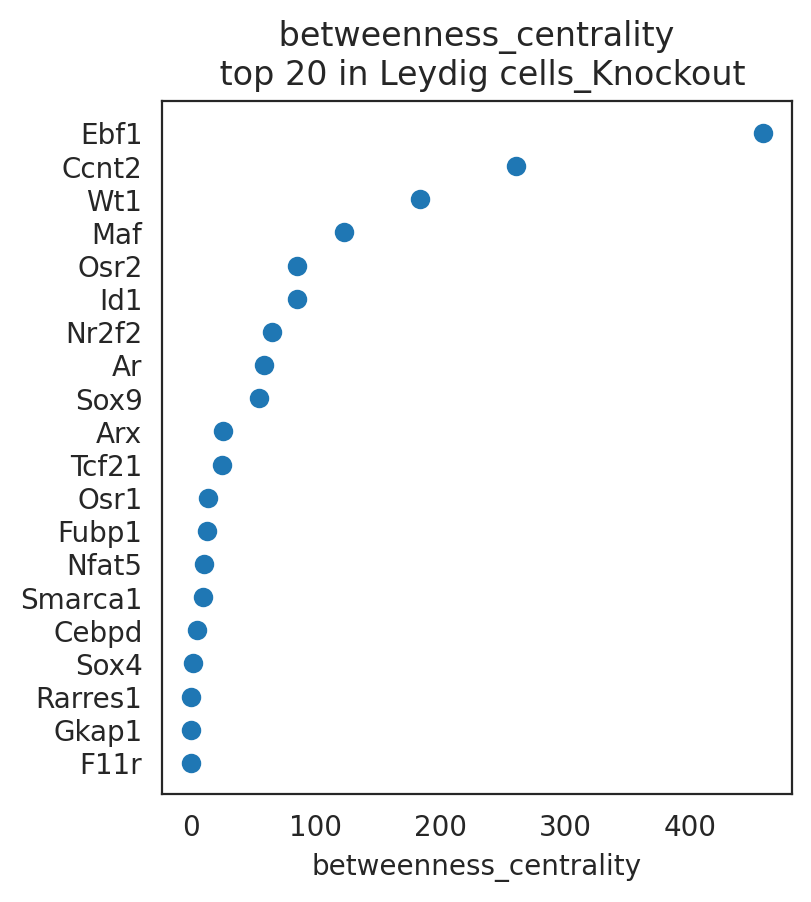

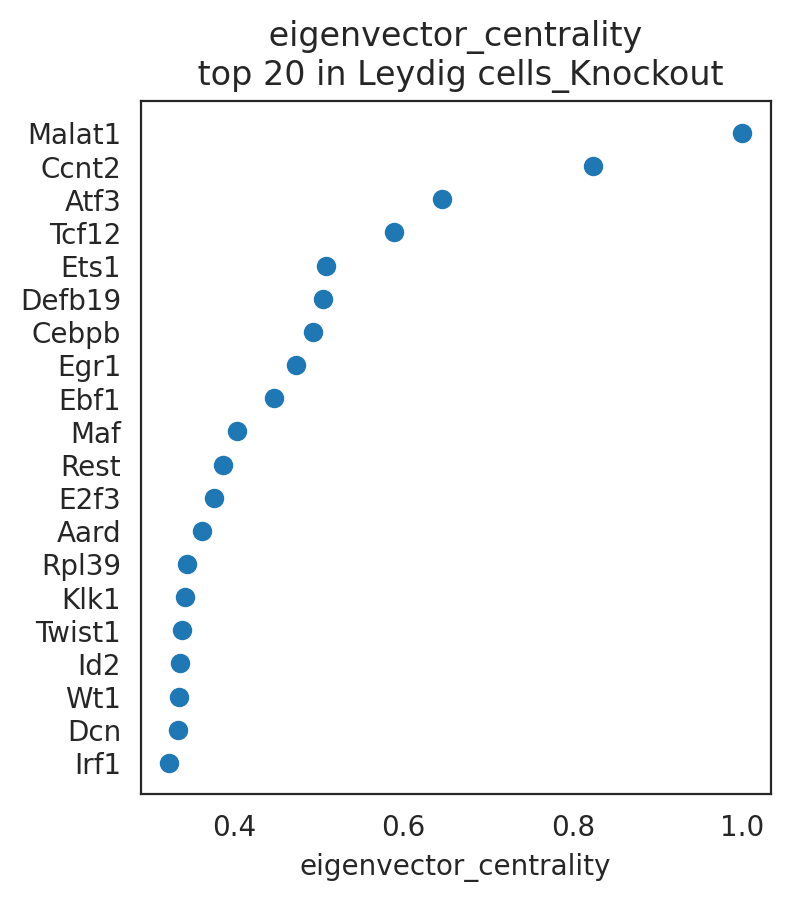

In [38]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="Leydig cells_Knockout", n_gene=20) #save=f"{save_folder}/ranked_score")

## 7.2. Network score comparison between two clusters


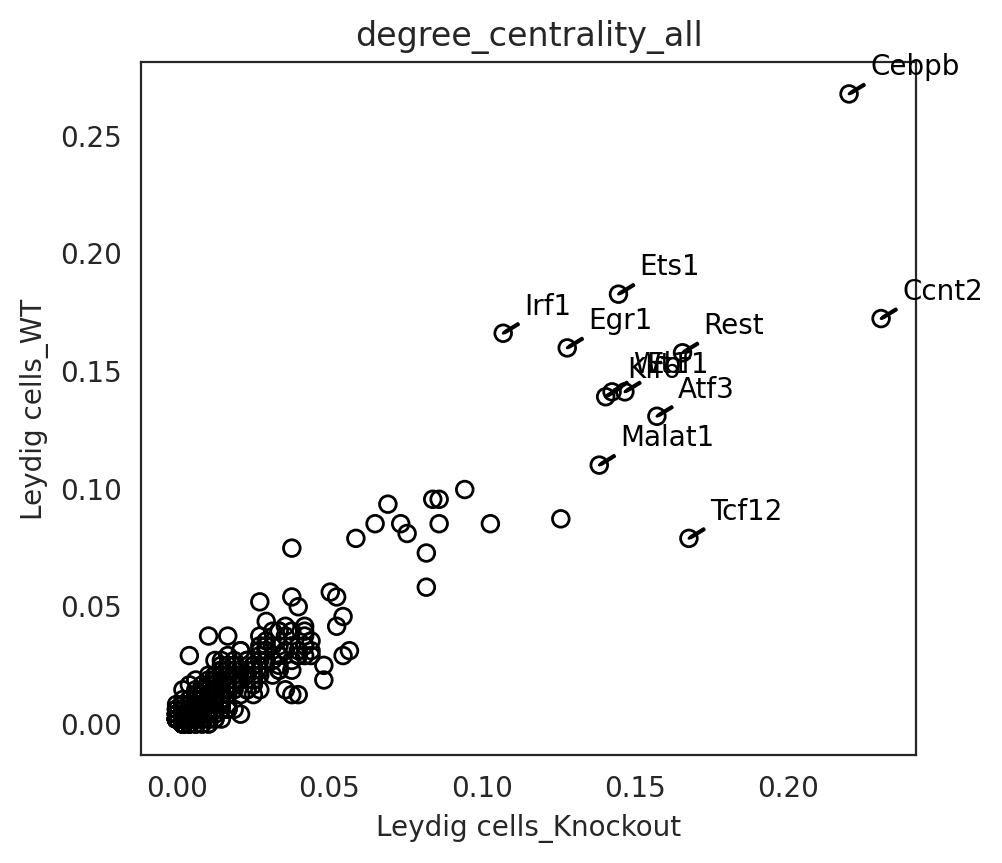

In [7]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="Leydig cells_Knockout", cluster2="Leydig cells_WT", 
                               percentile=98, save="degree_centrality_all.png")

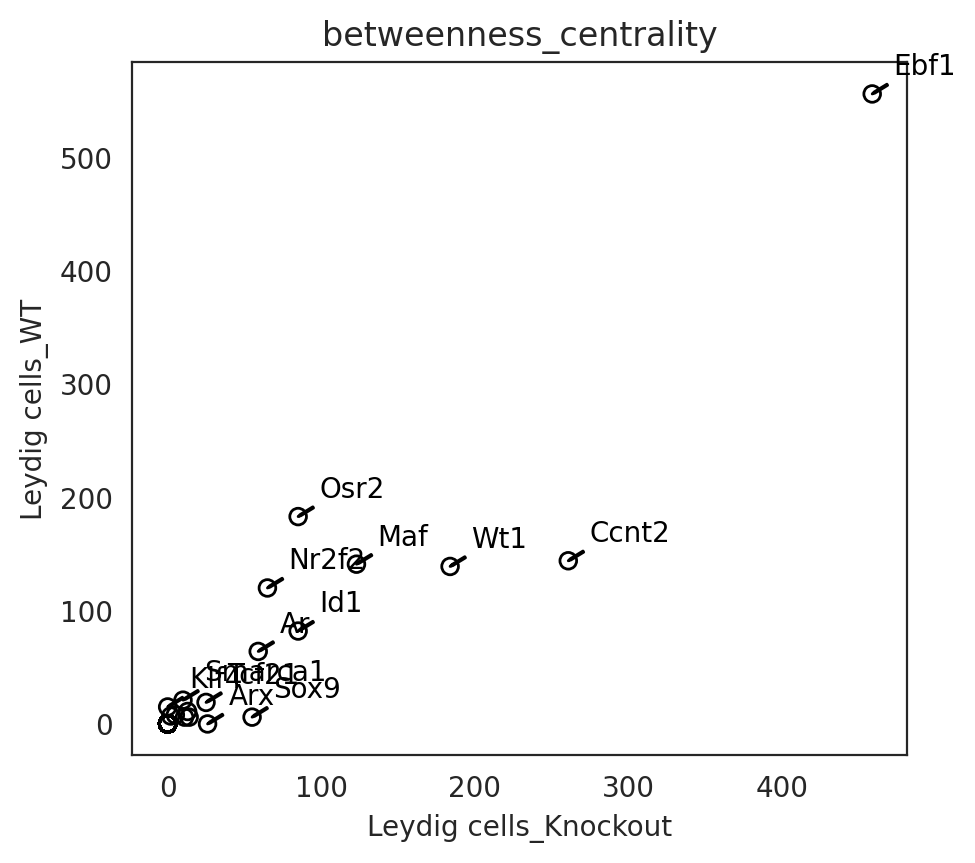

In [8]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="Leydig cells_Knockout", cluster2="Leydig cells_WT", 
                               percentile=98, save="betweenness_centrality")

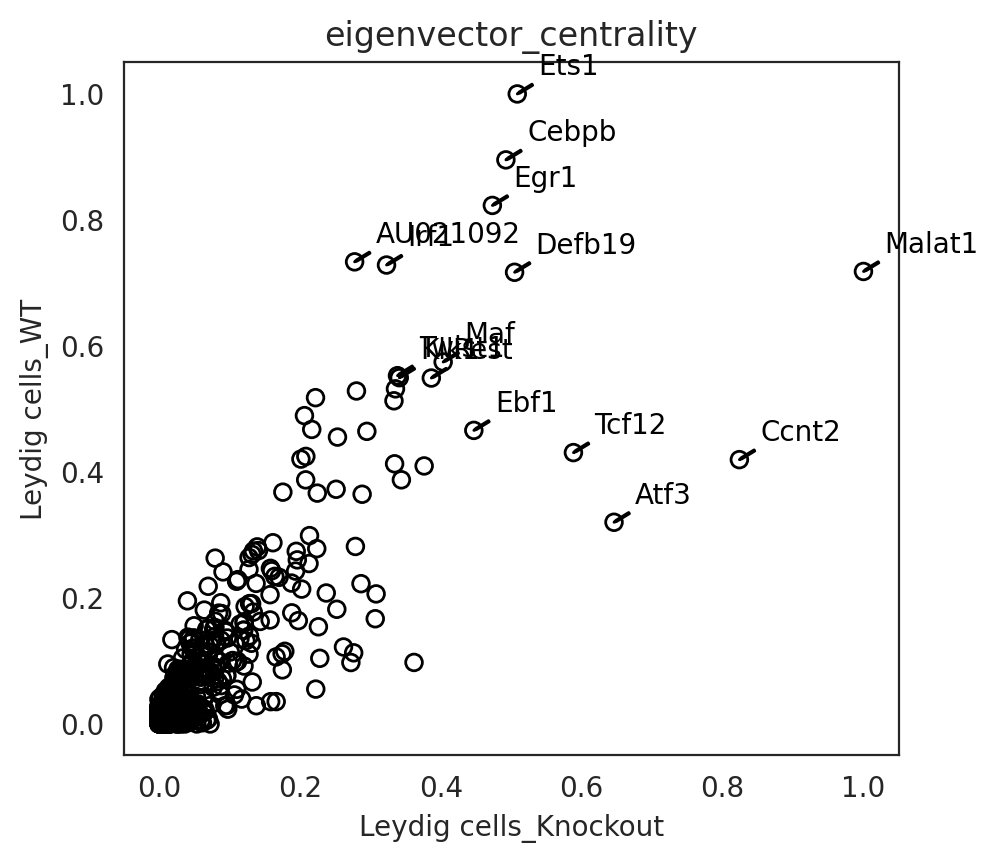

In [9]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="Leydig cells_Knockout", cluster2="Leydig cells_WT", 
                               percentile=98, save='eigenvector_centrality')

## 7.3. Network score dynamics

In [42]:
# Visualize Jund network score dynamics
#links.plot_score_per_cluster(goi="Jund")

In [43]:
cluster_name = "Leydig cells_Knockout"
ko_filtered_links_df = links.filtered_links[cluster_name]
ko_filtered_links_df.head(10)

source    target  coef_mean  coef_abs             p      -logp
29240     Egr1       Dcn   0.709298  0.709298  4.573248e-16  15.339775
64944    Ccnt2    Malat1   0.527601  0.527601  1.494095e-20  19.825622
62081     E2f3     Lhcgr   0.418086  0.418086  5.776865e-17  16.238308
30041     Atf3    Defb36   0.405598  0.405598  2.596127e-10   9.585674
3848      Irf1  AU021092   0.396155  0.396155  3.810000e-15  14.419075
108379   Rhox8    Tmsb4x   0.395712  0.395712  3.150919e-16  15.501563
29981     Ets1    Defb19  -0.388068  0.388068  3.799582e-19  18.420264
29974      Id2    Defb19   0.383337  0.383337  3.200969e-10   9.494719
60082   Twist1      Klk1   0.373257  0.373257  1.685466e-13  12.773280
30049     Ebf1    Defb36  -0.352502  0.352502  6.553424e-11  10.183532

In [38]:
cluster_name = "Leydig cells_WT"
wt_filtered_links_df = links.filtered_links[cluster_name]
wt_filtered_links_df.head(10)

source    target  coef_mean  coef_abs             p      -logp
99262      Egr1       Dcn   0.349157  0.349157  1.896662e-20  19.722010
16030      Egr1     Acadm   0.240507  0.240507  1.327091e-14  13.877099
173732    Cebpb    Hsd3b1   0.231046  0.231046  2.606876e-17  16.583880
11828   Bhlhe40  AU021092   0.229606  0.229606  6.283402e-16  15.201805
198353       Ar   Klk1b21   0.223610  0.223610  1.802144e-12  11.744211
99268    Tcf7l2       Dcn   0.210117  0.210117  5.742619e-13  12.240890
27084     Cebpb   Aldh1a1   0.201386  0.201386  6.428450e-18  17.191894
222856    Nr3c1       Mgp   0.189849  0.189849  5.681125e-20  19.245566
99250     Vezf1       Dcn   0.184490  0.184490  2.403974e-12  11.619070
316154    Cebpb     Rpl39   0.181363  0.181363  3.896619e-20  19.409312

In [1]:
merged = pd.merge(ko_filtered_links_df, wt_filtered_links_df, on='source', how='left')

## Additional analysis: important genes

In [12]:
# Load files with the following command.
links = co.load_hdf5(file_path="links.celloracle.links")


In [44]:
ko = links.merged_score[links.merged_score['cluster'] == 'Leydig cells_Knockout']
wt = links.merged_score[links.merged_score['cluster'] == 'Leydig cells_WT']

Tcf12


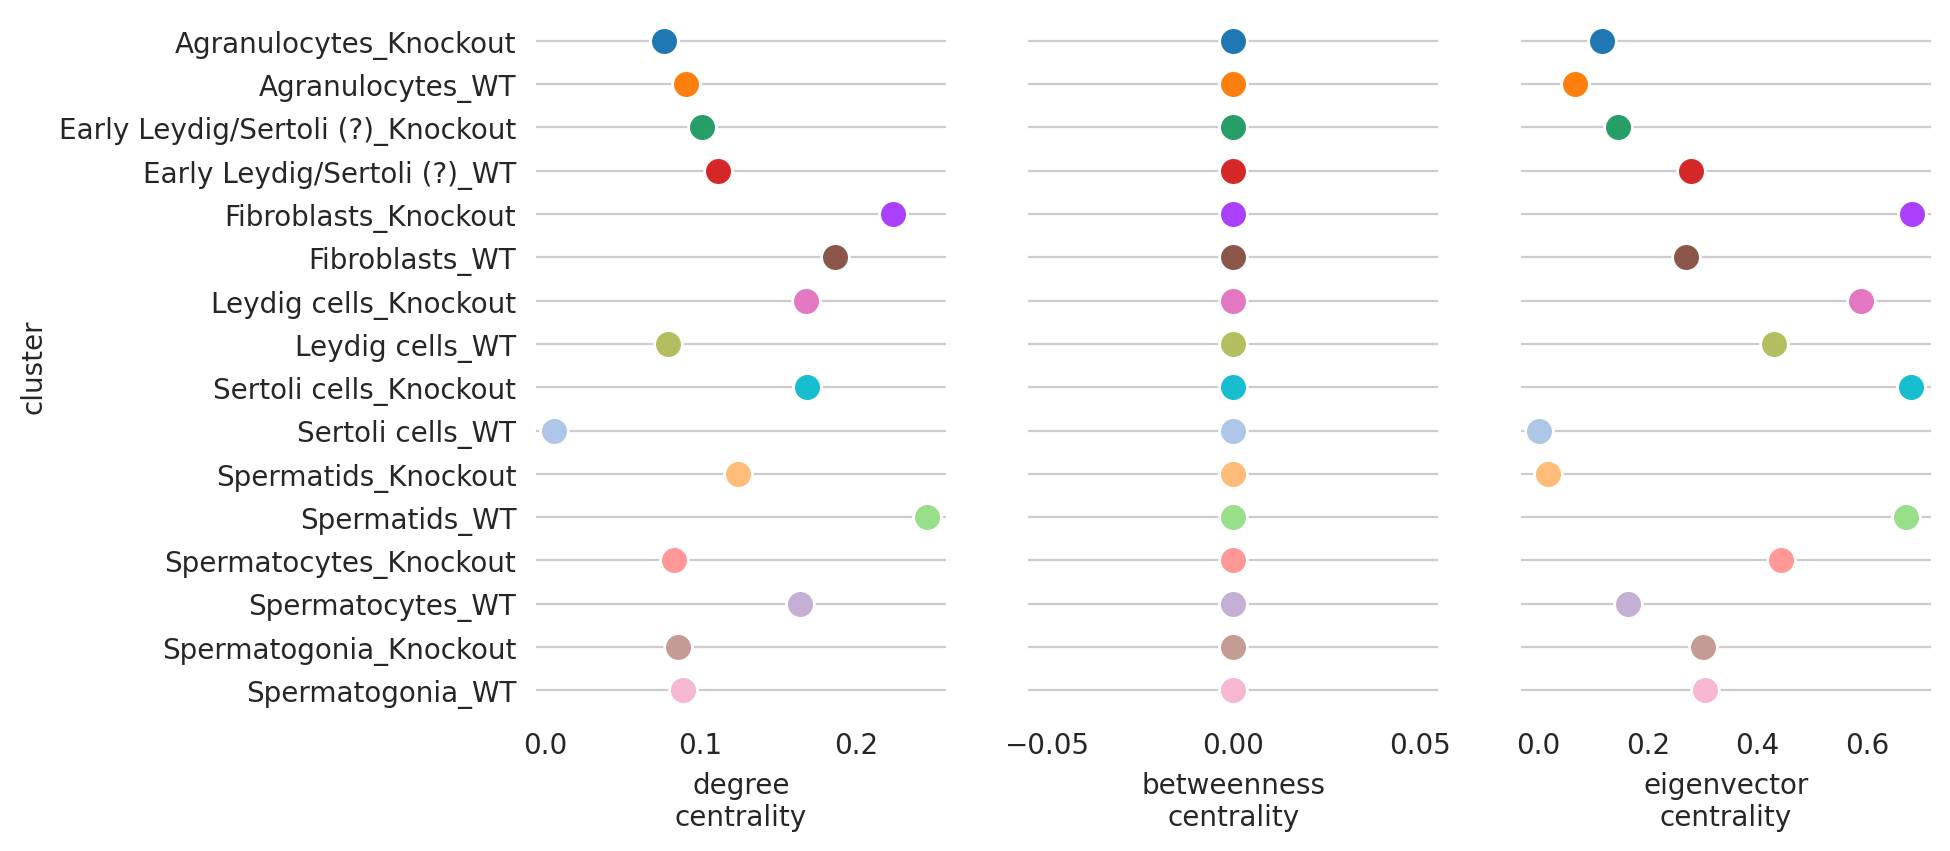

AttributeError: 'NoneType' object has no attribute 'loc'

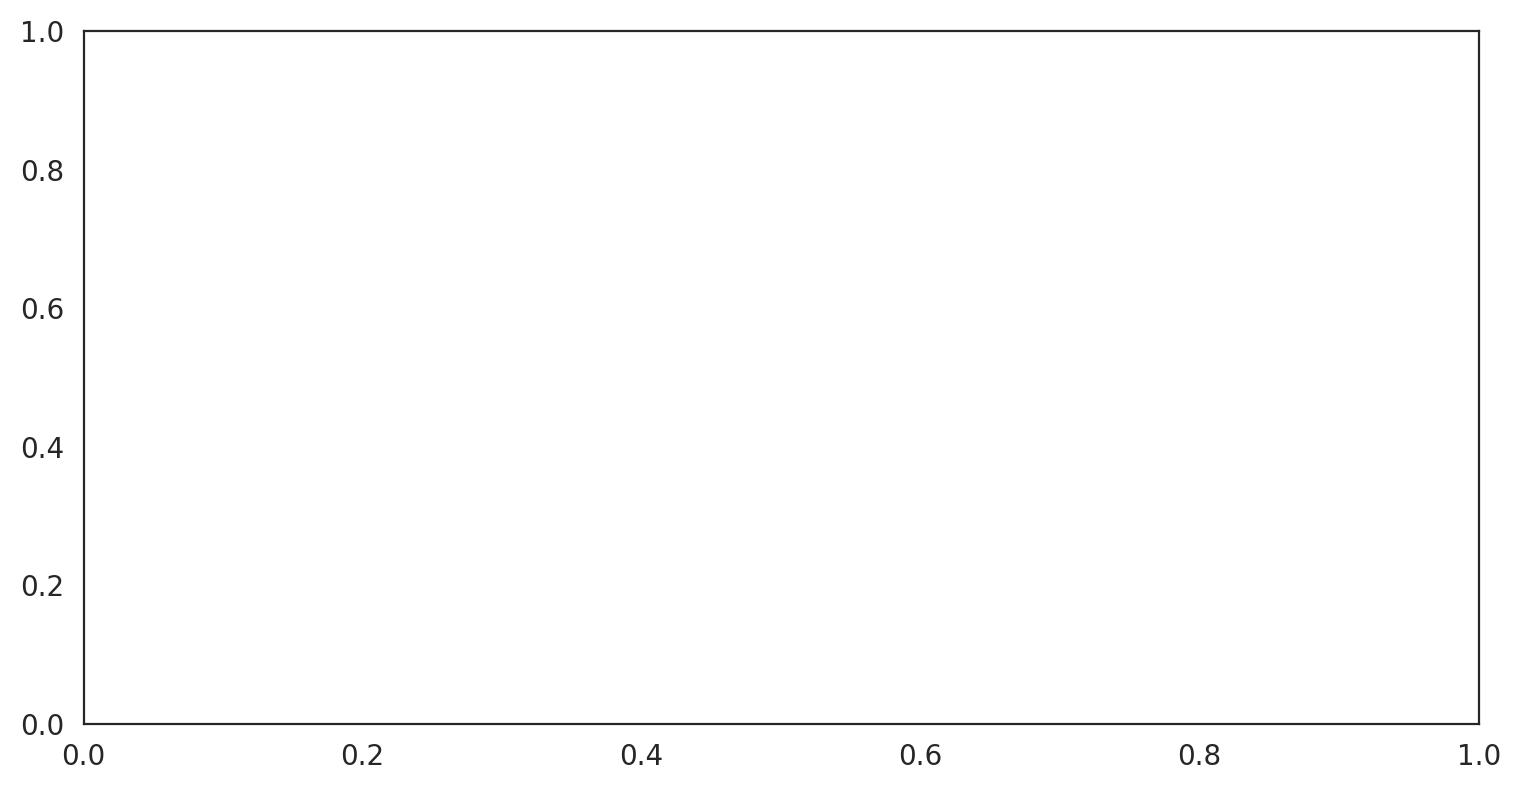

In [45]:
centrality = [('degree_centrality_all', 0.05), ('eigenvector_centrality', 0.4), ('betweenness_centrality', 10)]

#we will choose genes which have scores > than it is written above
# also difference between ko and wt should be the biggest

for i in centrality:
    valid_labels = [label for label in list(wt[abs(wt[i[0]] > i[1])].index) 
                if label in ko[abs(ko[i[0]] > i[1])].index]
    dif = abs(ko[i[0]].loc[valid_labels] - wt[i[0]].loc[valid_labels])
    dif.sort_values(ascending=False, inplace=True)
    for j in range(5):
        links.plot_score_per_cluster(goi=dif.index[j])

        #entropy plots
        fig, ax = plt.subplots()
        ax.scatter(links.entropy.loc[valid_labels].loc[dif.index[j]]['cluster'], links.entropy.loc[valid_labels].loc[dif.index[j]]['entropy_norm'])
        plt.xticks(rotation=-75)
        plt.savefig(f"./centrality_figs/entropy_{dif.index[j]}_{i[0]}.png", bbox_inches='tight', dpi=300)
        plt.close(fig)

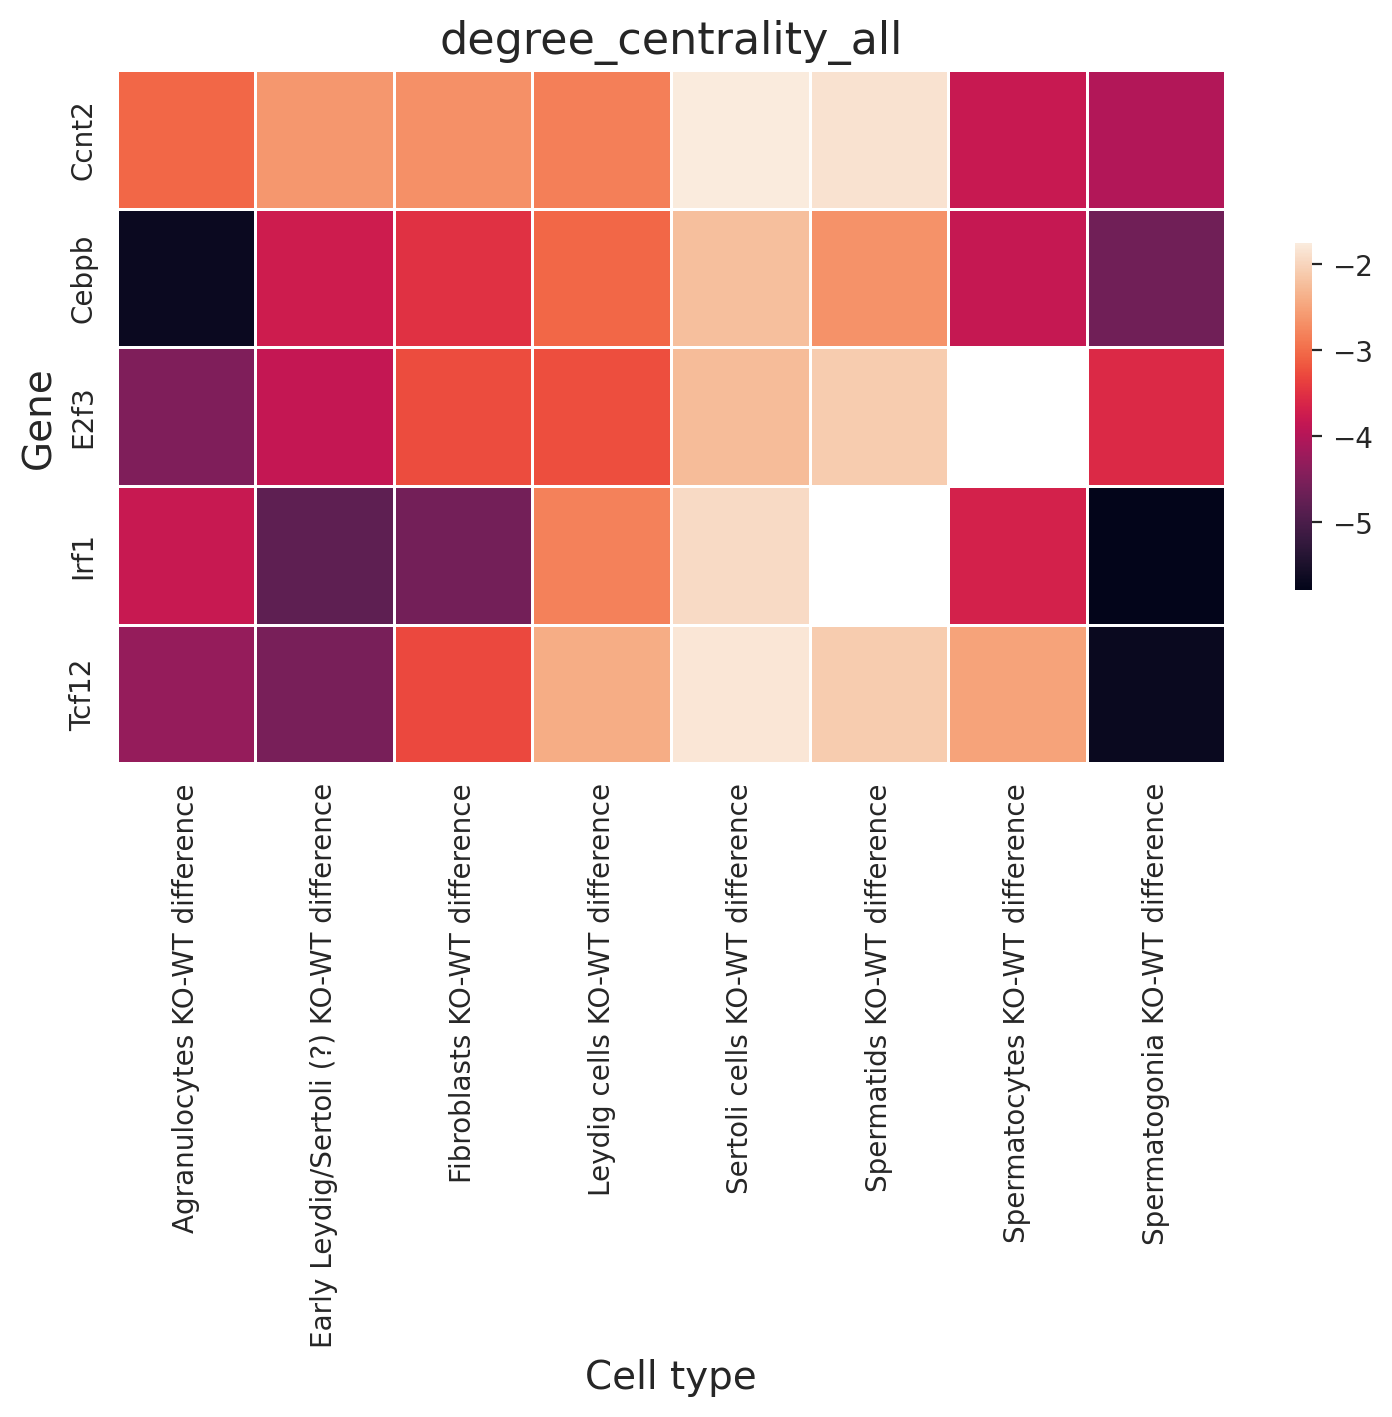

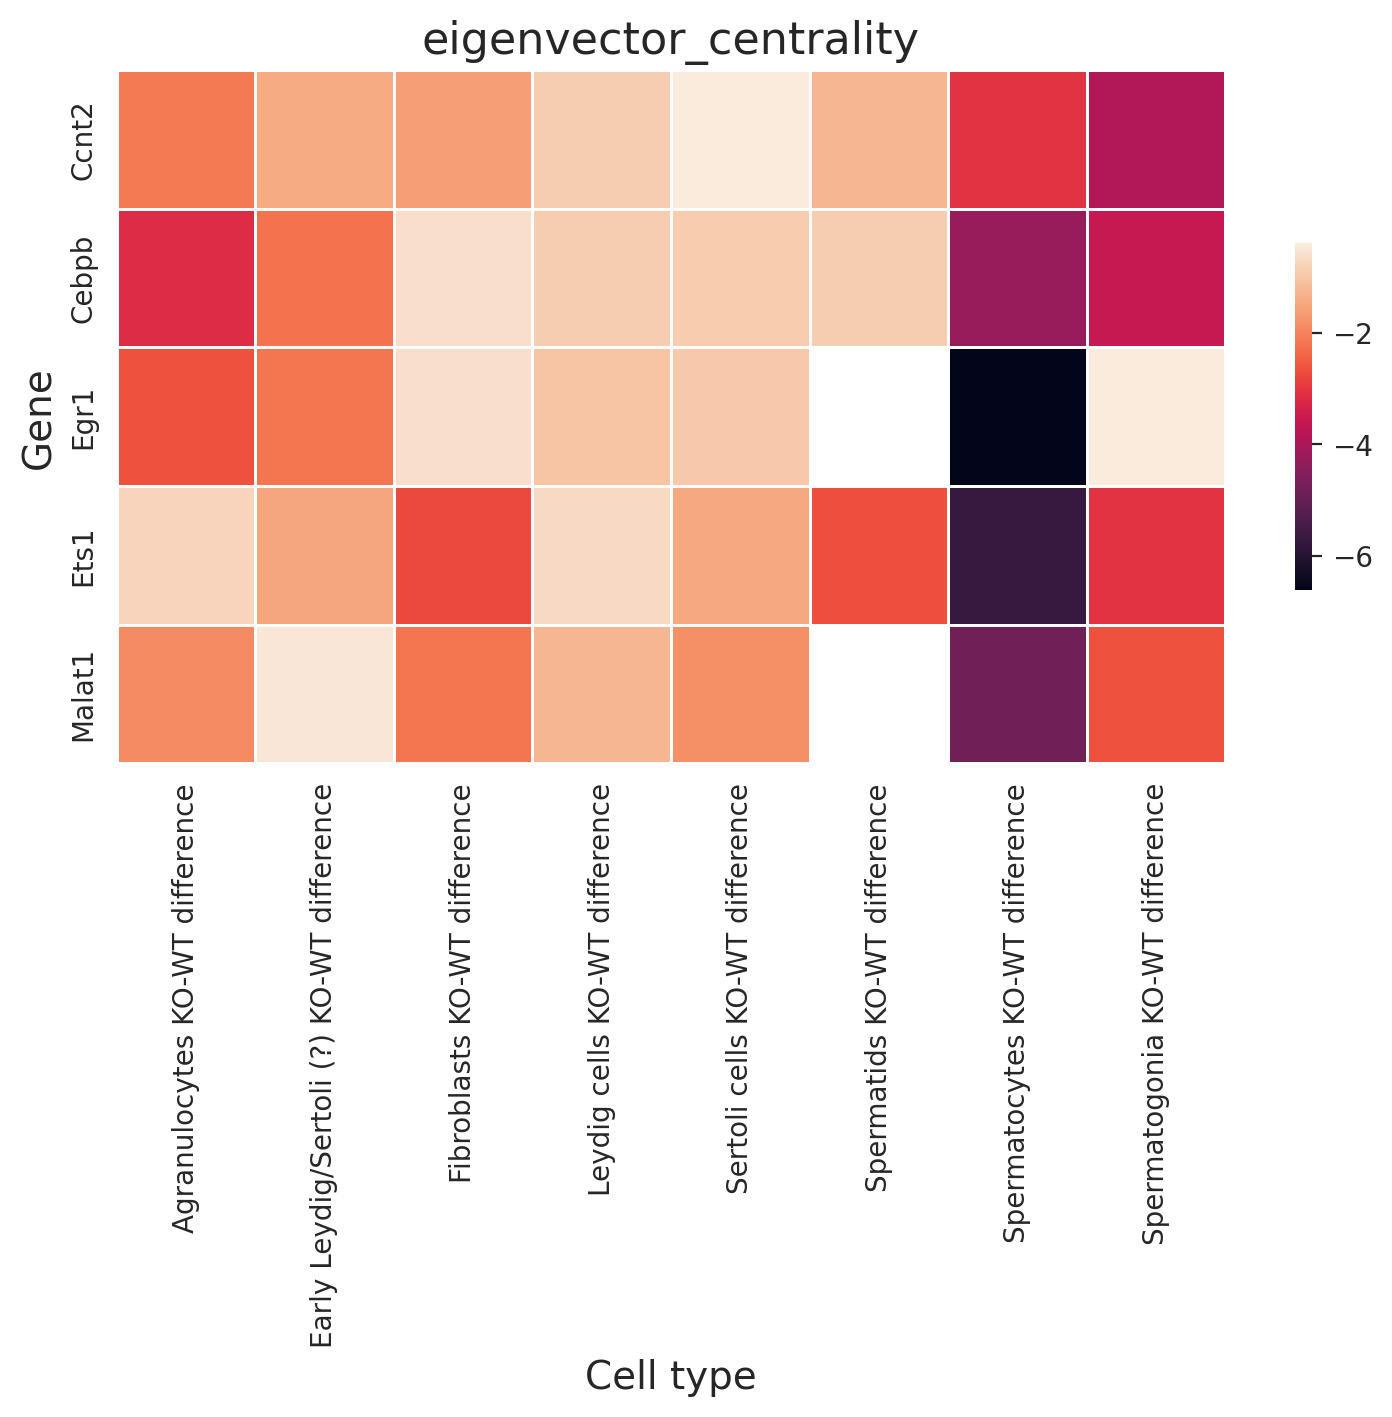

In [46]:
centrality = [('degree_centrality_all', 0.05), ('eigenvector_centrality', 0.4)] #, ('betweenness_centrality', 10)]

#we will choose genes which have scores > than it is written above
# also difference between ko and wt should be the biggest

#Firstly I will show only center and eigen because number of genes in betweenness <5 (=4)

for i in centrality:
    genes_of_interest = []
    #filtration: > than values in centrality var and then sorting by the difference between WT and KO
    valid_labels = [label for label in list(wt[abs(wt[i[0]] > i[1])].index) 
                if label in ko[abs(ko[i[0]] > i[1])].index]
    dif = abs(ko[i[0]].loc[valid_labels] - wt[i[0]].loc[valid_labels])
    dif.sort_values(ascending=False, inplace=True)
    #Write down top-genes:
    for j in range(5):
        genes_of_interest.append(dif.index[j])
    #Use it for heatmap data
    heatmap_data = links.merged_score.loc[genes_of_interest, [i[0], 'cluster']]
    heatmap_data['gene'] = heatmap_data.index
    heatmap_data = heatmap_data.pivot(index='gene', columns='cluster', values=i[0])

    #find absolute difference between KO and WT
    for k in [('Agranulocytes_Knockout', 'Agranulocytes_WT'),
       ('Early Leydig/Sertoli (?)_Knockout', 'Early Leydig/Sertoli (?)_WT'),
       ('Fibroblasts_Knockout', 'Fibroblasts_WT'), ('Leydig cells_Knockout',
       'Leydig cells_WT'), ('Sertoli cells_Knockout', 'Sertoli cells_WT'),
       ('Spermatids_Knockout', 'Spermatids_WT'), ('Spermatocytes_Knockout',
       'Spermatocytes_WT'), ('Spermatogonia_Knockout', 'Spermatogonia_WT')]:

        new_column_name = k[0].split(sep='_')[0] + ' KO-WT difference'
        values = list(abs(heatmap_data[k[0]] - heatmap_data[k[1]]))
        heatmap_data[new_column_name] = values
        
        heatmap_data = heatmap_data.drop([k[0], k[1]], axis=1)

    # Create a heatmap
    sns.heatmap(np.log(heatmap_data+0.0001),         # Annotate each cell with its value
            #cmap='coolwarm',     # Color palette (can also use 'viridis', 'magma', 'Blues', etc.)
            linewidths=0.5,      # Line thickness between cells
            linecolor='white',   # Line color between cells
            square=True,         # Make the heatmap square-shaped
            cbar_kws={'shrink': 0.5},  # Adjust color bar size
            xticklabels=True,    # Display x-axis tick labels
            yticklabels=True,    # Display y-axis tick labels
            fmt=".2f",           # Format the annotation values (e.g., 2 decimal points)
            #annot_kws={"size": 10, "weight": 'bold', 'color': 'black'},  # Customize annotation text
            cbar=True,           # Display the color bar
            robust=True,         # Use robust scaling (ignores extreme outliers)
            )

    # Title and labels
    plt.title(i[0], fontsize=16)
    plt.xlabel('Cell type', fontsize=14)
    plt.ylabel('Gene', fontsize=14)
    
    # Display the plot
    plt.show()

cluster  Agranulocytes_Knockout  Agranulocytes_WT  \
gene                                                
Ebf1                       37.0               0.0   
Nr5a1                       0.0               0.0   
Osr2                        0.0               0.0   
Wt1                         0.0               0.0   

cluster  Early Leydig/Sertoli (?)_Knockout  Early Leydig/Sertoli (?)_WT  \
gene                                                                      
Ebf1                                  10.0                         21.0   
Nr5a1                                  0.0                          0.0   
Osr2                                   0.0                          0.0   
Wt1                                  336.0                        195.0   

cluster  Fibroblasts_Knockout  Fibroblasts_WT  Leydig cells_Knockout  \
gene                                                                   
Ebf1                   1463.0           694.0                   15.0   
Nr5a1                     0.0             0.0                   19.0   
Osr2                      0.0             0.0                   15.0   
Wt1                     109.0            83.0                   27.0   

cluster  Leydig cells_WT  Sertoli cells_Knockout  Sertoli cells_WT  \
gene                                                                 
Ebf1                53.0                     0.0               0.0   
Nr5a1               31.0                     0.0               0.0   
Osr2                26.0                     NaN               0.0   
Wt1                 24.0                     0.0               0.0   

cluster  Spermatids_Knockout  Spermatids_WT  Spermatocytes_Knockout  \
gene                                                                  
Ebf1                     0.0            0.0                     0.0   
Nr5a1                    0.0            0.0                     0.0   
Osr2                     NaN            0.0                     NaN   
Wt1                      0.0            0.0                     0.0   

cluster  Spermatocytes_WT  Spermatogonia_Knockout  Spermatogonia_WT  
gene                                                                 
Ebf1                  0.0                     0.0               0.0  
Nr5a1                 0.0                     0.0               0.0  
Osr2                  NaN                     0.0               0.0  
Wt1                   0.0                     0.0               0.0

cluster  Agranulocytes KO-WT difference  \
gene                                      
Ebf1                               37.0   
Nr5a1                               0.0   
Osr2                                0.0   
Wt1                                 0.0   

cluster  Early Leydig/Sertoli (?) KO-WT difference  \
gene                                                 
Ebf1                                          11.0   
Nr5a1                                          0.0   
Osr2                                           0.0   
Wt1                                          141.0   

cluster  Fibroblasts KO-WT difference  Leydig cells KO-WT difference  \
gene                                                                   
Ebf1                            769.0                           38.0   
Nr5a1                             0.0                           12.0   
Osr2                              0.0                           11.0   
Wt1                              26.0                            3.0   

cluster  Sertoli cells KO-WT difference  Spermatids KO-WT difference  \
gene                                                                   
Ebf1                                0.0                          0.0   
Nr5a1                               0.0                          0.0   
Osr2                                NaN                          NaN   
Wt1                                 0.0                          0.0   

cluster  Spermatocytes KO-WT difference  Spermatogonia KO-WT difference  
gene                                                                     
Ebf1                                0.0                             0.0  
Nr5a1                               0.0                             0.0  
Osr2                                NaN                             0.0  
Wt1                                 0.0                             0.0

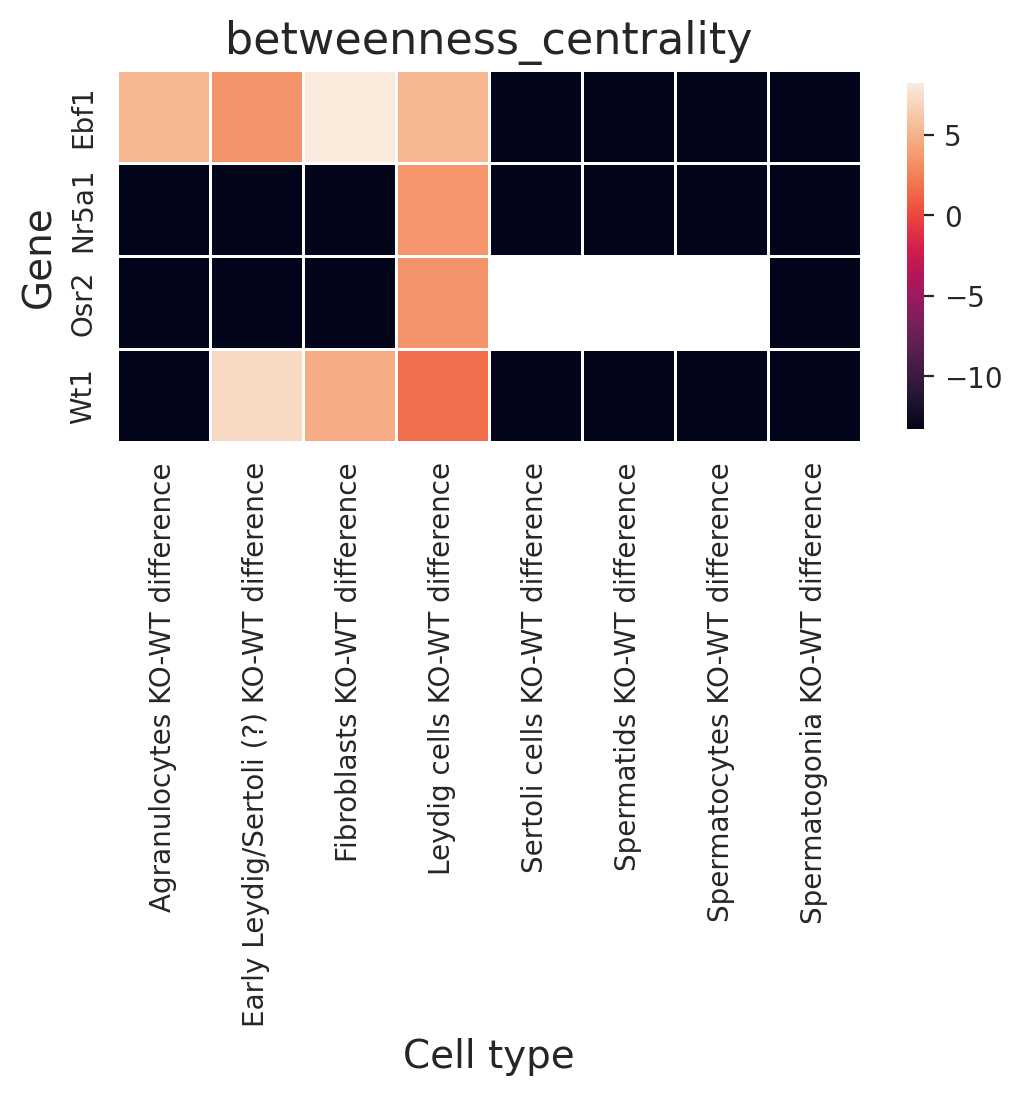

In [121]:
centrality = [('betweenness_centrality', 10)]

#we will choose genes which have scores > than it is written above
# also difference between ko and wt should be the biggest
for i in centrality:
    genes_of_interest = []
    valid_labels = [label for label in list(wt[abs(wt[i[0]] > i[1])].index) 
                if label in ko[abs(ko[i[0]] > i[1])].index]
    dif = abs(ko[i[0]].loc[valid_labels] - wt[i[0]].loc[valid_labels])
    dif.sort_values(ascending=False, inplace=True)
    for j in range(4):
        genes_of_interest.append(dif.index[j])
    heatmap_data = links.merged_score.loc[genes_of_interest, [i[0], 'cluster']]
    heatmap_data['gene'] = heatmap_data.index
    heatmap_data = heatmap_data.pivot(index='gene', columns='cluster', values=i[0])
    display(heatmap_data)
    for k in [('Agranulocytes_Knockout', 'Agranulocytes_WT'),
       ('Early Leydig/Sertoli (?)_Knockout', 'Early Leydig/Sertoli (?)_WT'),
       ('Fibroblasts_Knockout', 'Fibroblasts_WT'), ('Leydig cells_Knockout',
       'Leydig cells_WT'), ('Sertoli cells_Knockout', 'Sertoli cells_WT'),
       ('Spermatids_Knockout', 'Spermatids_WT'), ('Spermatocytes_Knockout',
       'Spermatocytes_WT'), ('Spermatogonia_Knockout', 'Spermatogonia_WT')]:

        new_column_name = k[0].split(sep='_')[0] + ' KO-WT difference'
        values = list(abs(heatmap_data[k[0]] - heatmap_data[k[1]]))
        heatmap_data[new_column_name] = values
        
        heatmap_data = heatmap_data.drop([k[0], k[1]], axis=1)
    display(heatmap_data)
    # Create a heatmap
    sns.heatmap(np.log2(heatmap_data+0.0001),         # Annotate each cell with its value
            #cmap='coolwarm',     # Color palette (can also use 'viridis', 'magma', 'Blues', etc.)
            linewidths=0.5,      # Line thickness between cells
            linecolor='white',   # Line color between cells
            square=True,         # Make the heatmap square-shaped
            cbar_kws={'shrink': 0.5},  # Adjust color bar size
            xticklabels=True,    # Display x-axis tick labels
            yticklabels=True,    # Display y-axis tick labels
            fmt=".2f",           # Format the annotation values (e.g., 2 decimal points)
            #annot_kws={"size": 10, "weight": 'bold', 'color': 'black'},  # Customize annotation text
            cbar=True,           # Display the color bar
            robust=True,         # Use robust scaling (ignores extreme outliers)
            )

    # Title and labels
    plt.title(i[0], fontsize=16)
    plt.xlabel('Cell type', fontsize=14)
    plt.ylabel('Gene', fontsize=14)
    
    # Display the plot
    plt.show()

In [47]:
#the cell to find the most crucial genes according to celloracle to intersect it with DEGs
centrality = [('degree_centrality_all', 0.05), ('eigenvector_centrality', 0.4), ('betweenness_centrality', 10)]

#we will choose genes which have scores > than it is written above
# also difference between ko and wt should be the biggest
list_of_crucial_genes = []

for i in centrality:
    valid_labels = [label for label in list(wt[abs(wt[i[0]] > i[1])].index) 
                if label in ko[abs(ko[i[0]] > i[1])].index]
    dif = abs(ko[i[0]].loc[valid_labels] - wt[i[0]].loc[valid_labels])
    dif.sort_values(ascending=False, inplace=True)
    list_of_crucial_genes += list(dif.index)
print(len(list_of_crucial_genes))

46


In [48]:
degs = pd.read_csv('DEGs.csv')
degs = list(degs['x'])

In [1]:
#degs = list(map(str, degs))
#', '.join(degs)

In [49]:
list(set(degs) & set(list_of_crucial_genes))

['Nr2f2', 'Klf6', 'Maf', 'Id3', 'Id1', 'Id2', 'Egr1', 'Ebf1']

In [50]:
print(', '.join(list(set(degs) & set(list_of_crucial_genes))))

Nr2f2, Klf6, Maf, Id3, Id1, Id2, Egr1, Ebf1


## Additional analysis: TF

In [55]:
# Load files with the following command.
links = co.load_hdf5(file_path="cdk8.19_mouse_seurat_CO_notebook.celloracle.links")

In [56]:
links.get_network_entropy()
#links.entropy

Высокое значение энтропии - значит, что ген работает unpredictable. Мы хотим найти ТФ, которые имеют маленькую энтропию клеточно-специфично. 
Начнем с клеток Лейдига. Смотрим ТФ у которых большое изменение в клетках Лейдига и маленькое изменение в других кластерах. 

In [57]:
entropy = links.entropy
entropy['gene'] = entropy.index
entropy = entropy.pivot(index='gene', columns='cluster', values='entropy_norm')

Text(0.5, 1.0, 'Entropy of genes of different clusters')

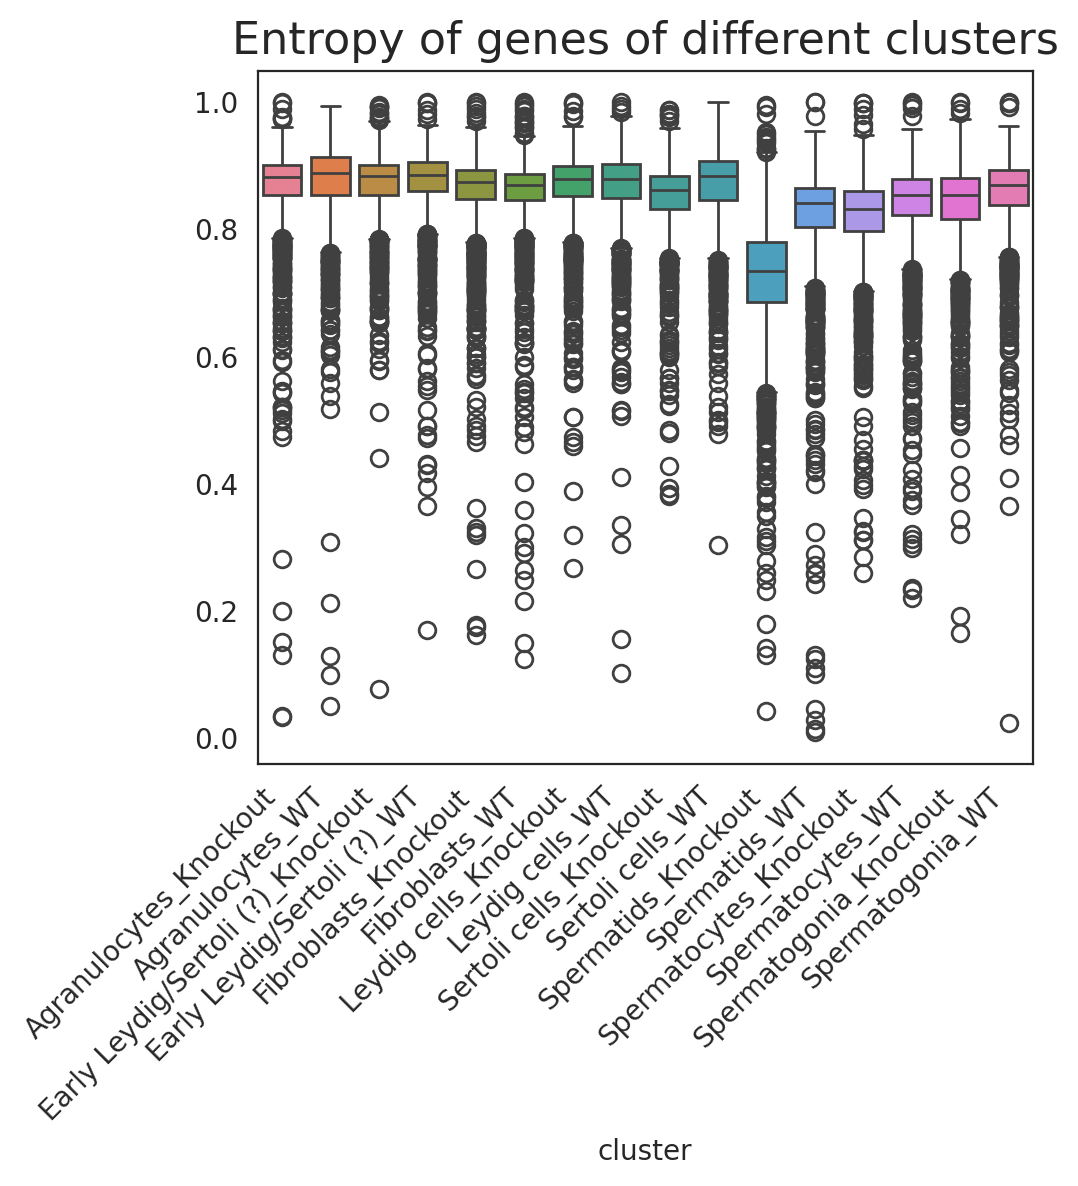

In [58]:
sns.boxplot(data=entropy)
plt.xticks(rotation=45, ha="right")
plt.title('Entropy of genes of different clusters', fontsize=16)

In [59]:
for k in [('Agranulocytes_Knockout', 'Agranulocytes_WT'),
       ('Early Leydig/Sertoli (?)_Knockout', 'Early Leydig/Sertoli (?)_WT'),
       ('Fibroblasts_Knockout', 'Fibroblasts_WT'), ('Leydig cells_Knockout',
       'Leydig cells_WT'), ('Sertoli cells_Knockout', 'Sertoli cells_WT'),
       ('Spermatids_Knockout', 'Spermatids_WT'), ('Spermatocytes_Knockout',
       'Spermatocytes_WT'), ('Spermatogonia_Knockout', 'Spermatogonia_WT')]:

        new_column_name = k[0].split(sep='_')[0] + ' KO-WT difference'
        values = list(abs(entropy[k[0]] - entropy[k[1]]))
        entropy[new_column_name] = values
        
        entropy = entropy.drop([k[0], k[1]], axis=1)
entropy['gene'] = entropy.index

Найдем те гены, энтропия которых меняется между состояниями сильнее всего. Но сначала отфильтруем ТФ.

In [60]:
tf_deg = pd.read_csv('tf_from_degs_esbl.csv')
#TF list from DEGs

tf = pd.read_csv('Mouse_TFs_Kinases_webpage-3-30-2017.csv')
#all mouse TFs

In [14]:
#tf_deg[tf_deg['Gene name'].isin(entropy['gene'])]
#140/145 DEGs TFs are here
#That's nothing special

In [61]:
tf = tf.dropna()
tf.columns = tf.iloc[0]
tf = tf.drop(5)

tf - 1482 genes
<br>
entropy - 4218 genes
<br>
tf from entropy - 322 genes

In [62]:
entropy_tf = entropy[entropy['gene'].isin(tf['Gene Symbol'])]

In [12]:
# sns.boxplot(data=entropy_tf)
# plt.xticks(rotation=45, ha="right")
# plt.title('Title', fontsize=16)
#plot for a difference between clusters entropy

In [63]:
entropy_tf['mean'] = entropy_tf.iloc[:, :7].mean(axis=1)

In [64]:
entropy_tf

cluster  Agranulocytes KO-WT difference  \
gene                                      
Aff2                           0.000551   
Ar                             0.030963   
Arid2                          0.086025   
Arid4b                         0.008021   
Arx                            0.028089   
...                                 ...   
Zfp820                         0.016194   
Zfp956                         0.012071   
Zglp1                          0.036956   
Zic1                           0.024534   
Zic4                           0.035818   

cluster  Early Leydig/Sertoli (?) KO-WT difference  \
gene                                                 
Aff2                                      0.062242   
Ar                                        0.005144   
Arid2                                     0.020632   
Arid4b                                    0.019643   
Arx                                       0.017780   
...                                            ...   
Zfp820                                    0.012900   
Zfp956                                    0.025329   
Zglp1                                     0.077751   
Zic1                                      0.029758   
Zic4                                      0.040016   

cluster  Fibroblasts KO-WT difference  Leydig cells KO-WT difference  \
gene                                                                   
Aff2                         0.015921                       0.018324   
Ar                           0.019354                       0.006062   
Arid2                        0.083117                       0.024420   
Arid4b                       0.010129                       0.007603   
Arx                          0.030676                       0.028491   
...                               ...                            ...   
Zfp820                       0.024415                       0.000462   
Zfp956                       0.025270                       0.015782   
Zglp1                        0.018991                       0.019310   
Zic1                              NaN                       0.014838   
Zic4                         0.016927                       0.044702   

cluster  Sertoli cells KO-WT difference  Spermatids KO-WT difference  \
gene                                                                   
Aff2                           0.060203                     0.084892   
Ar                             0.005504                     0.194254   
Arid2                          0.042933                     0.238341   
Arid4b                         0.088673                     0.135812   
Arx                            0.081902                          NaN   
...                                 ...                          ...   
Zfp820                         0.054050                     0.061188   
Zfp956                         0.046531                          NaN   
Zglp1                          0.053811                          NaN   
Zic1                                NaN                          NaN   
Zic4                           0.041218                          NaN   

cluster  Spermatocytes KO-WT difference  Spermatogonia KO-WT difference  \
gene                                                                      
Aff2                           0.006758                        0.005698   
Ar                             0.043541                        0.045694   
Arid2                          0.100130                        0.049423   
Arid4b                         0.000355                        0.007157   
Arx                                 NaN                        0.000278   
...                                 ...                             ...   
Zfp820                         0.033799                        0.014060   
Zfp956                         0.034981                        0.002776   
Zglp1                          0.019659                        0.017098   
Zic1                           0.02641

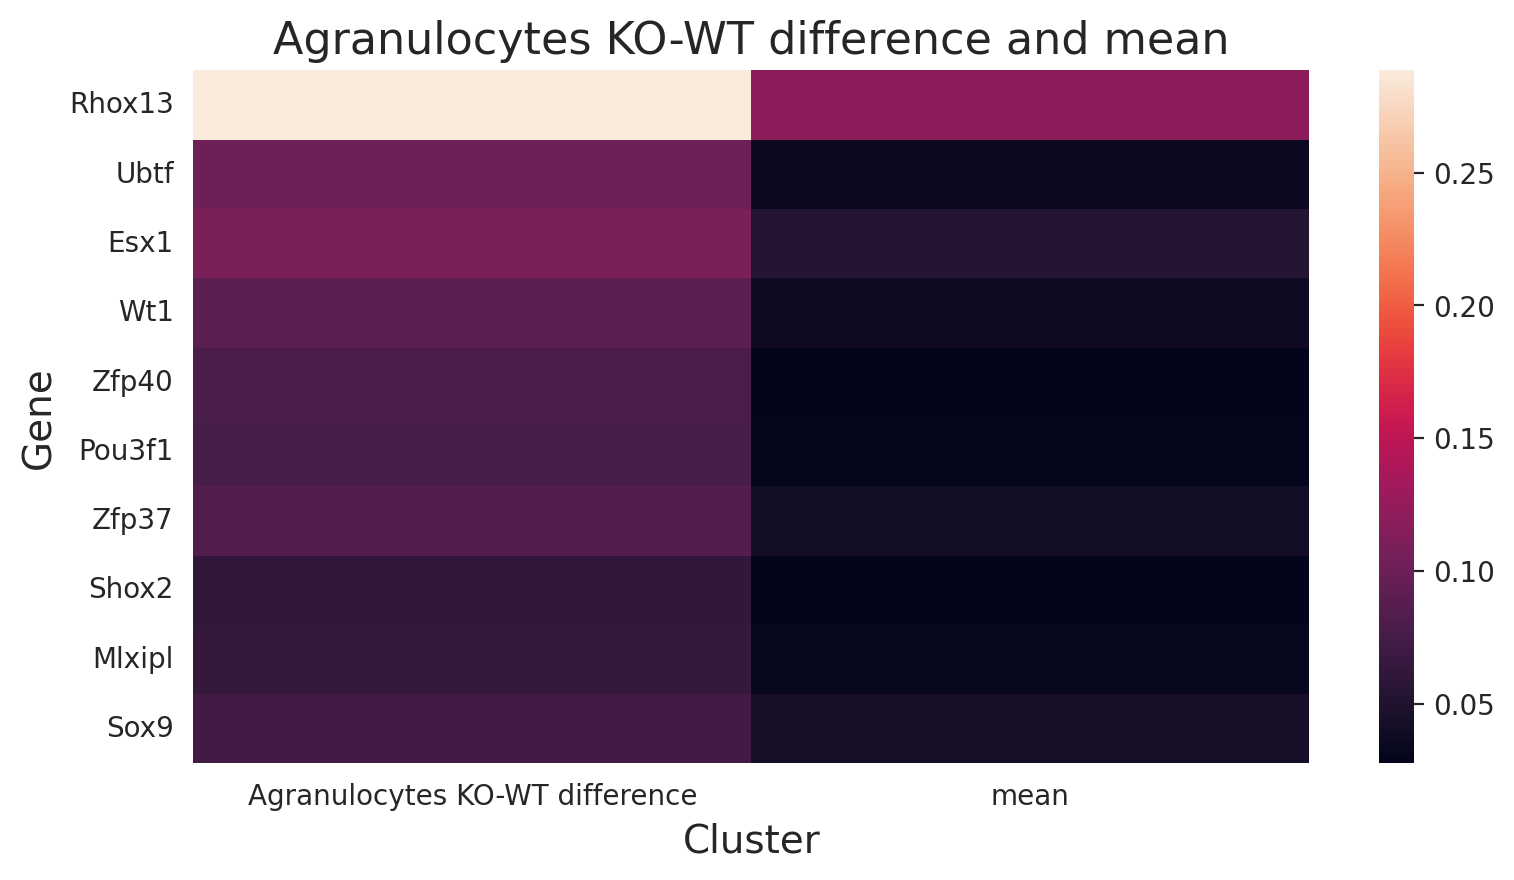

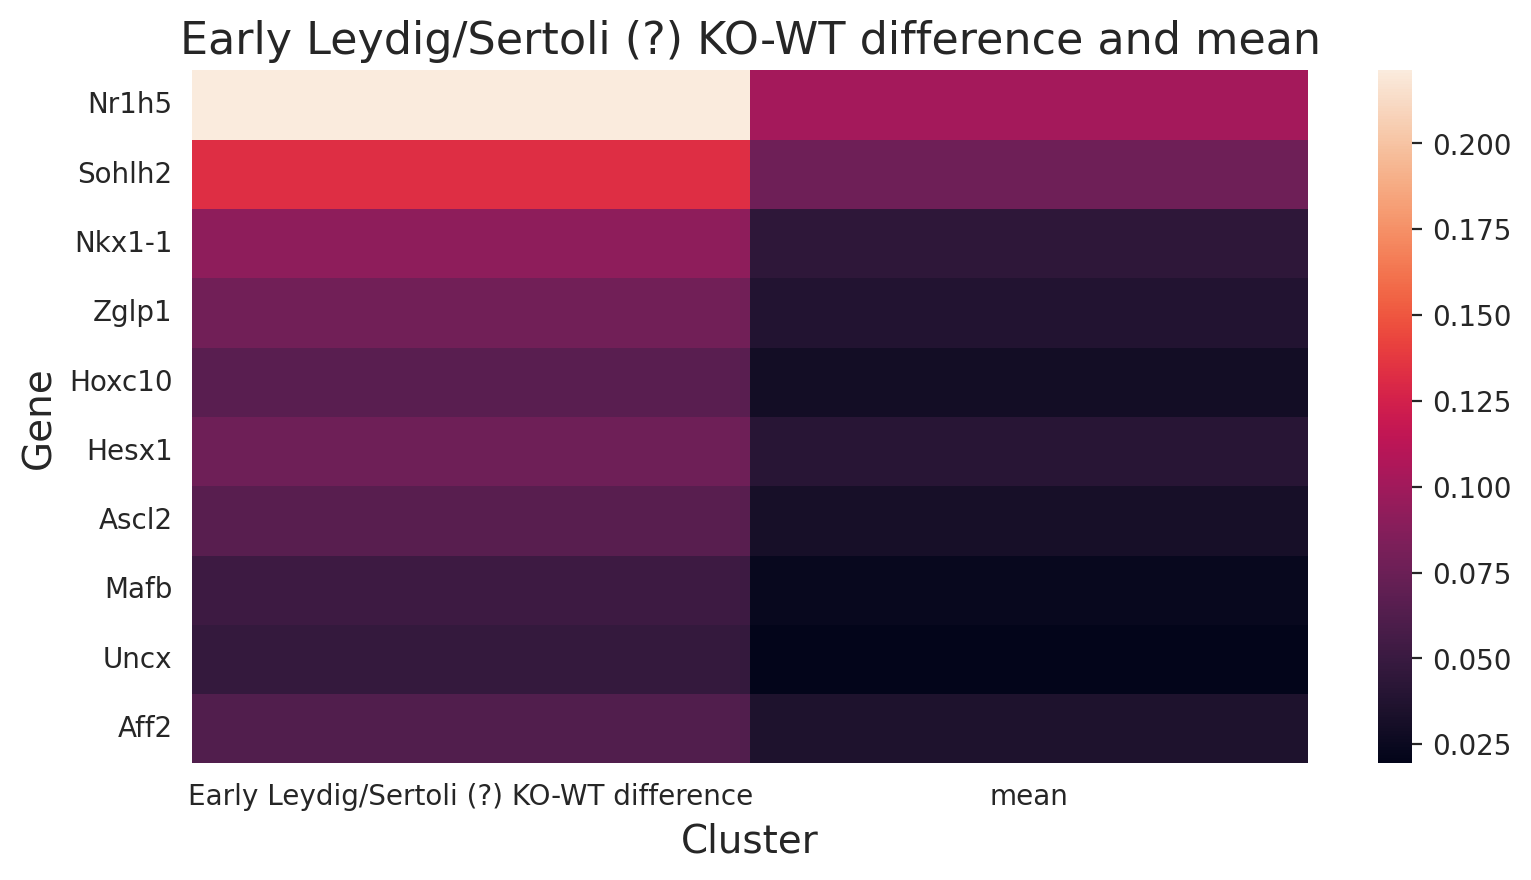

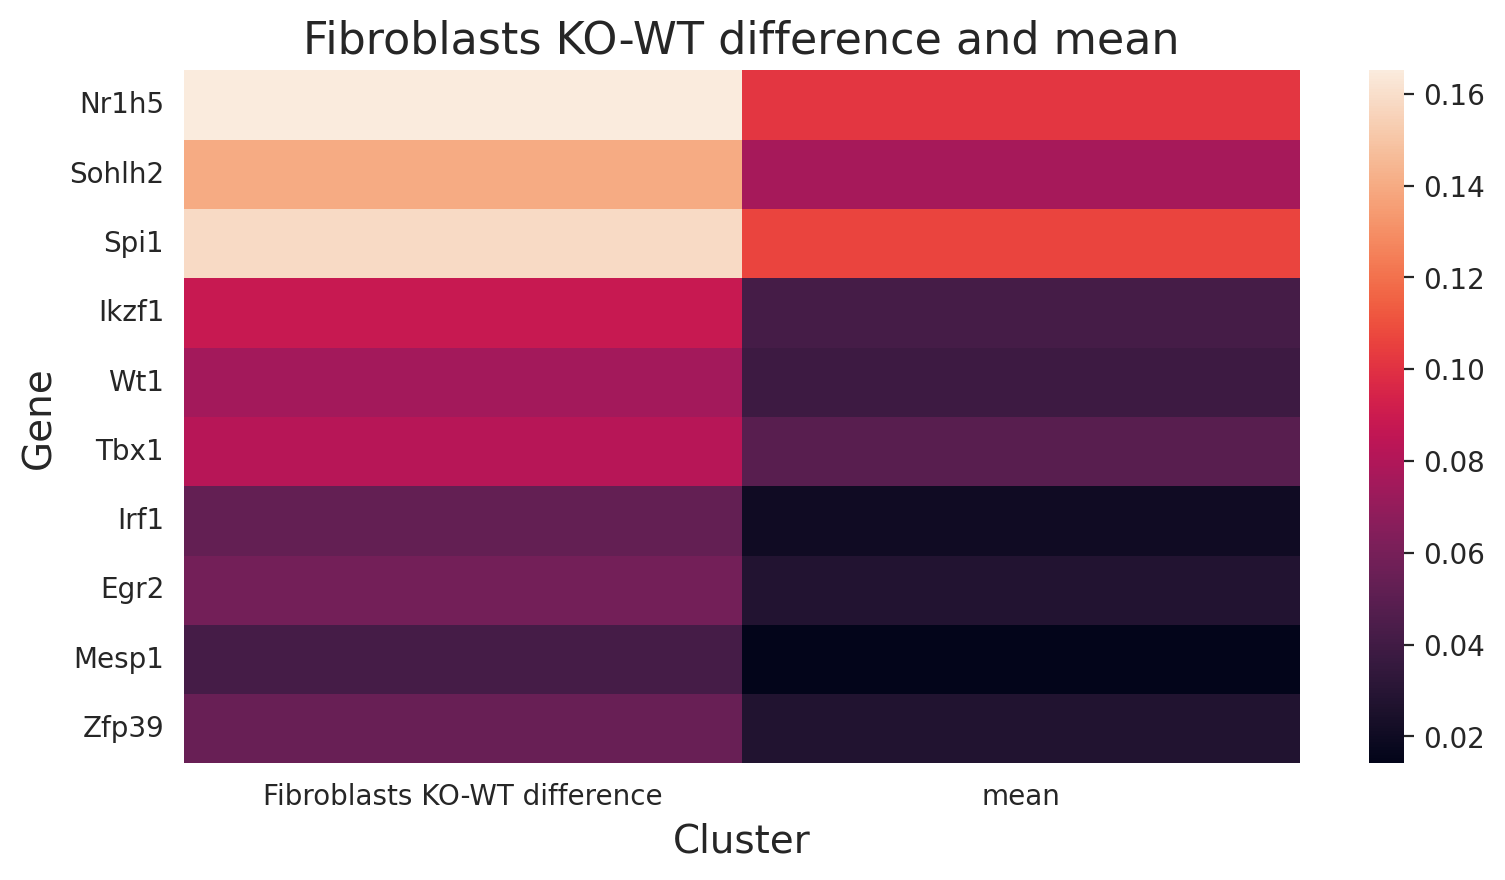

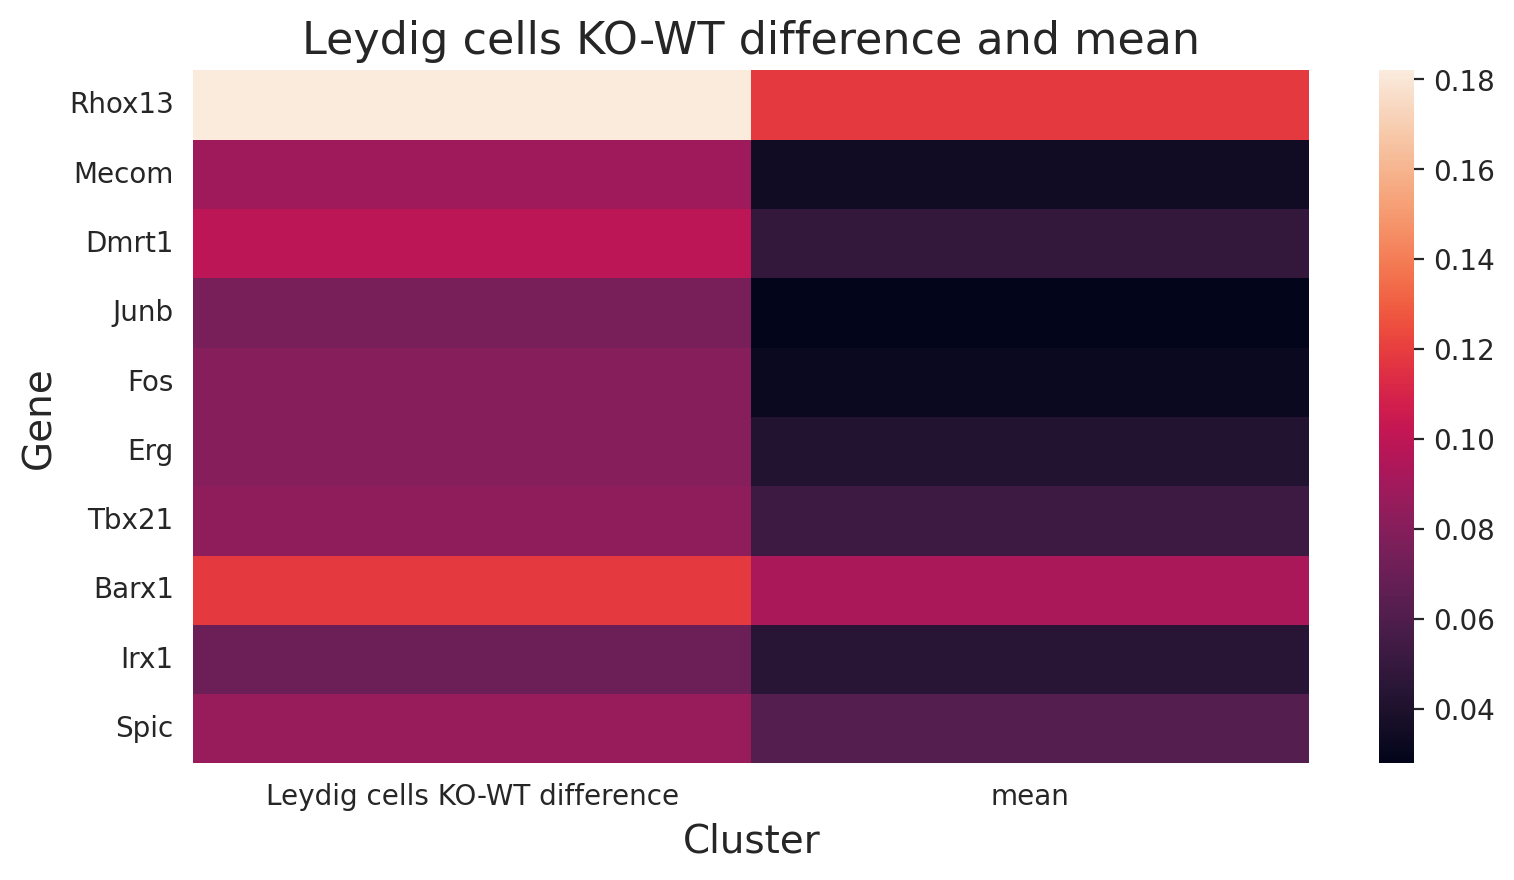

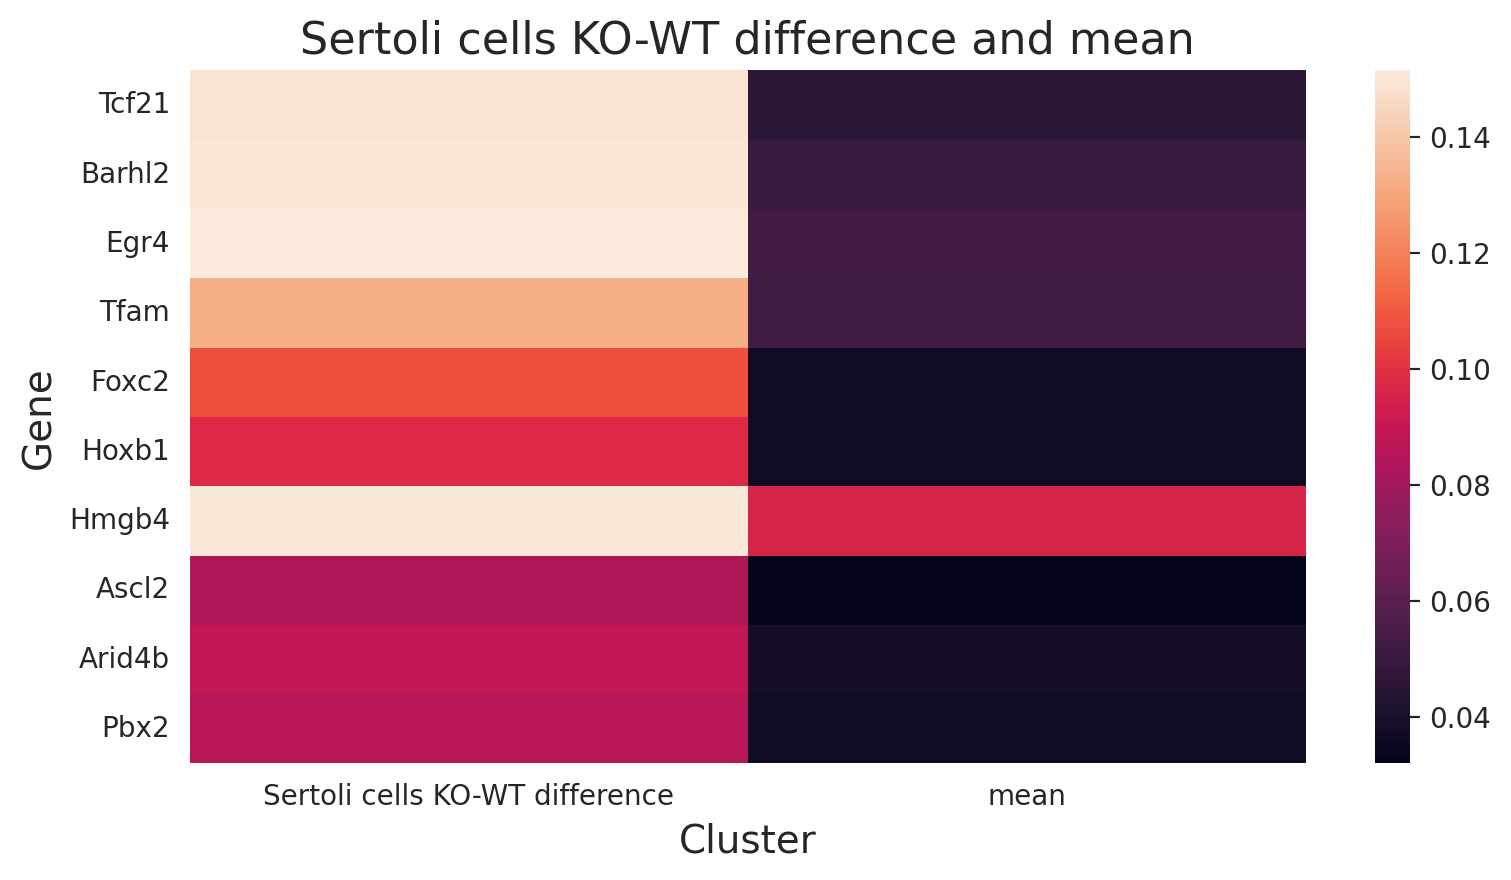

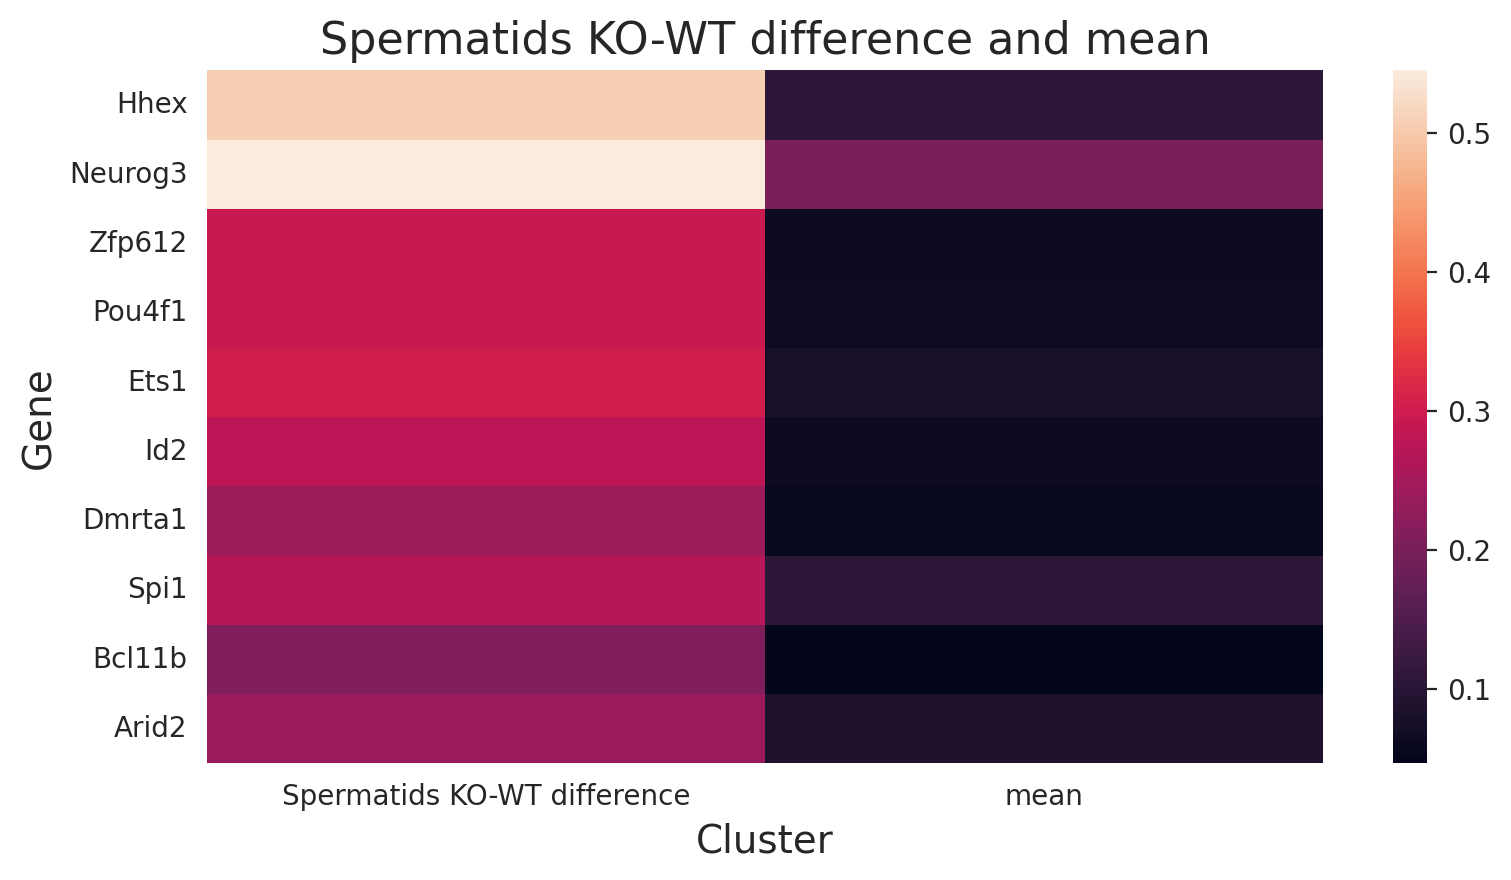

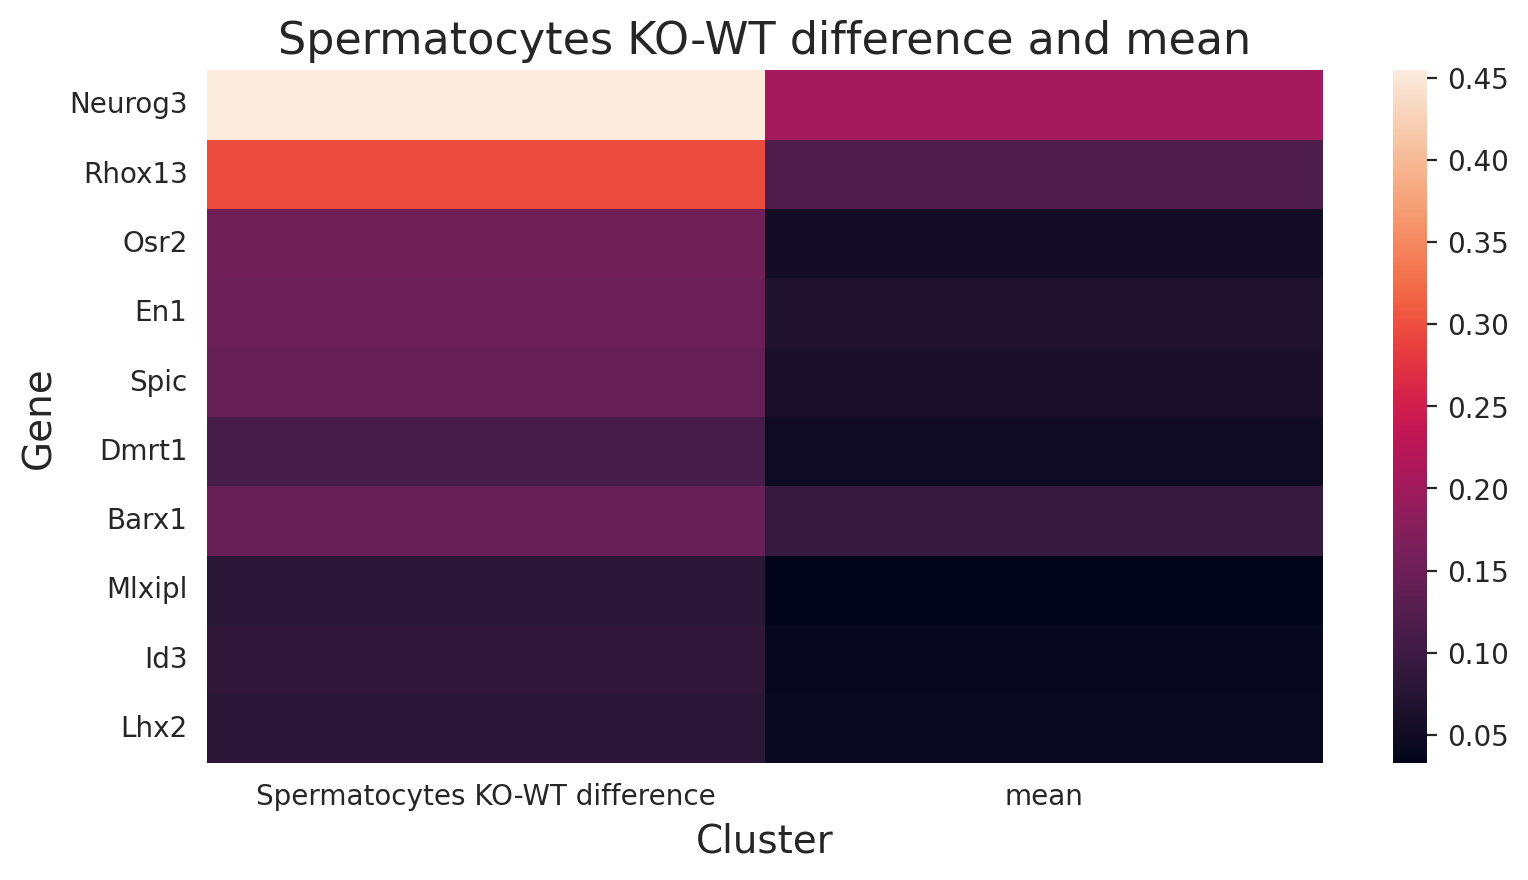

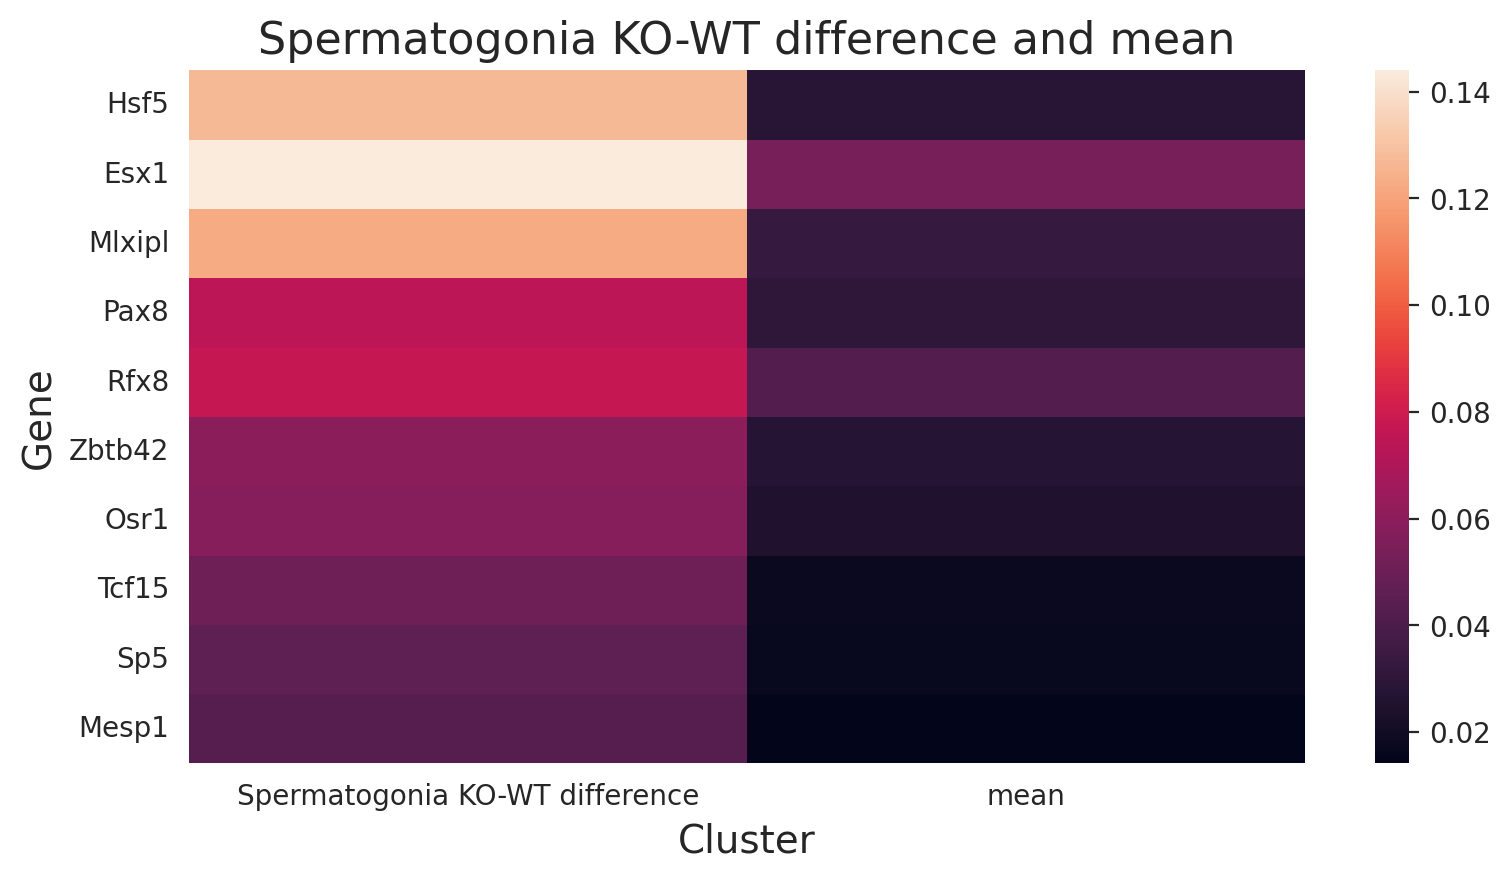

In [60]:
important_tf = []
for i in entropy_tf.columns[:-2]:
    heatmap = entropy_tf[entropy_tf[i] > entropy_tf['mean']]
    heatmap['difference'] = abs(entropy_tf['mean'] - entropy_tf[i])
    heatmap = heatmap.sort_values(by=['difference'], ascending=False)
    heatmap = heatmap.loc[:, [i, 'mean']].head(10)
    important_tf += list(heatmap.index[0:len(heatmap.index)])
    sns.heatmap(heatmap.loc[:, [i, 'mean']])
    plt.title(i+' and mean', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Gene', fontsize=14)
    #plt.savefig(i+"_heatmap.png")
    plt.show()

In [61]:
print(important_tf)

['Rhox13', 'Ubtf', 'Esx1', 'Wt1', 'Zfp40', 'Pou3f1', 'Zfp37', 'Shox2', 'Mlxipl', 'Sox9', 'Nr1h5', 'Sohlh2', 'Nkx1-1', 'Zglp1', 'Hoxc10', 'Hesx1', 'Ascl2', 'Mafb', 'Uncx', 'Aff2', 'Nr1h5', 'Sohlh2', 'Spi1', 'Ikzf1', 'Wt1', 'Tbx1', 'Irf1', 'Egr2', 'Mesp1', 'Zfp39', 'Rhox13', 'Mecom', 'Dmrt1', 'Junb', 'Fos', 'Erg', 'Tbx21', 'Barx1', 'Irx1', 'Spic', 'Tcf21', 'Barhl2', 'Egr4', 'Tfam', 'Foxc2', 'Hoxb1', 'Hmgb4', 'Ascl2', 'Arid4b', 'Pbx2', 'Hhex', 'Neurog3', 'Zfp612', 'Pou4f1', 'Ets1', 'Id2', 'Dmrta1', 'Spi1', 'Bcl11b', 'Arid2', 'Neurog3', 'Rhox13', 'Osr2', 'En1', 'Spic', 'Dmrt1', 'Barx1', 'Mlxipl', 'Id3', 'Lhx2', 'Hsf5', 'Esx1', 'Mlxipl', 'Pax8', 'Rfx8', 'Zbtb42', 'Osr1', 'Tcf15', 'Sp5', 'Mesp1']


In [82]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [7, 4.5]
plt.rcParams["savefig.dpi"] = 500

(0.5, 1.0)

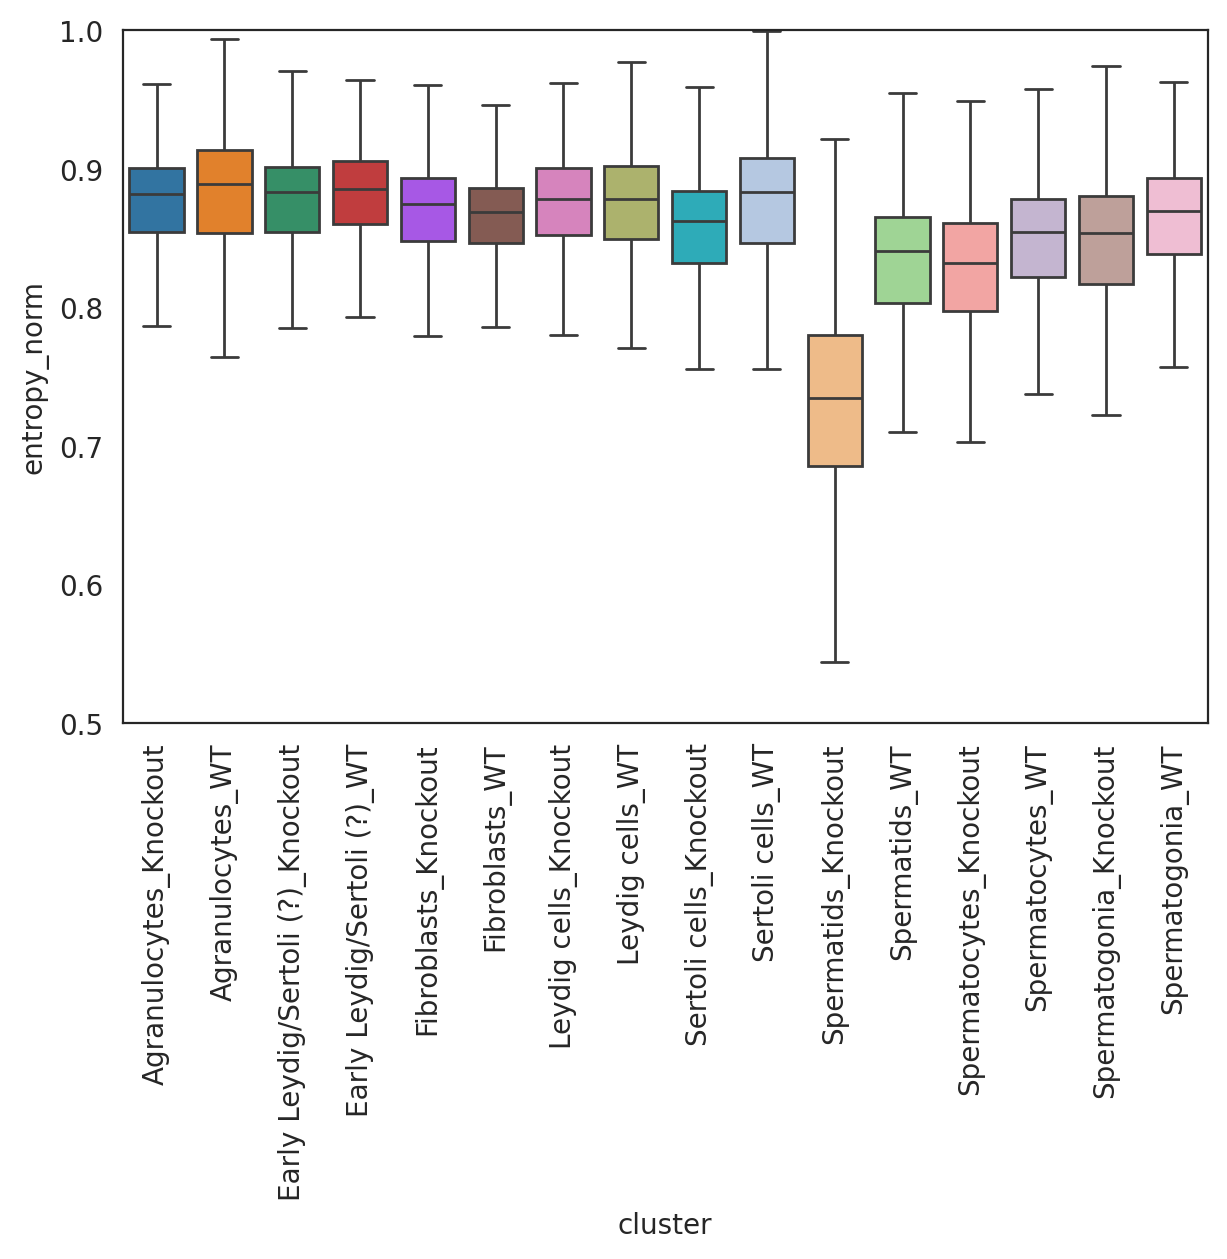

In [83]:
ax = sns.boxplot(data=links.entropy, x="cluster", y="entropy_norm",
                palette=links.palette.palette.values,
                order=links.palette.index.values, fliersize=0.0)

ax.tick_params(axis="x", rotation=90)
ax.set_ylim([0.5,1.0])

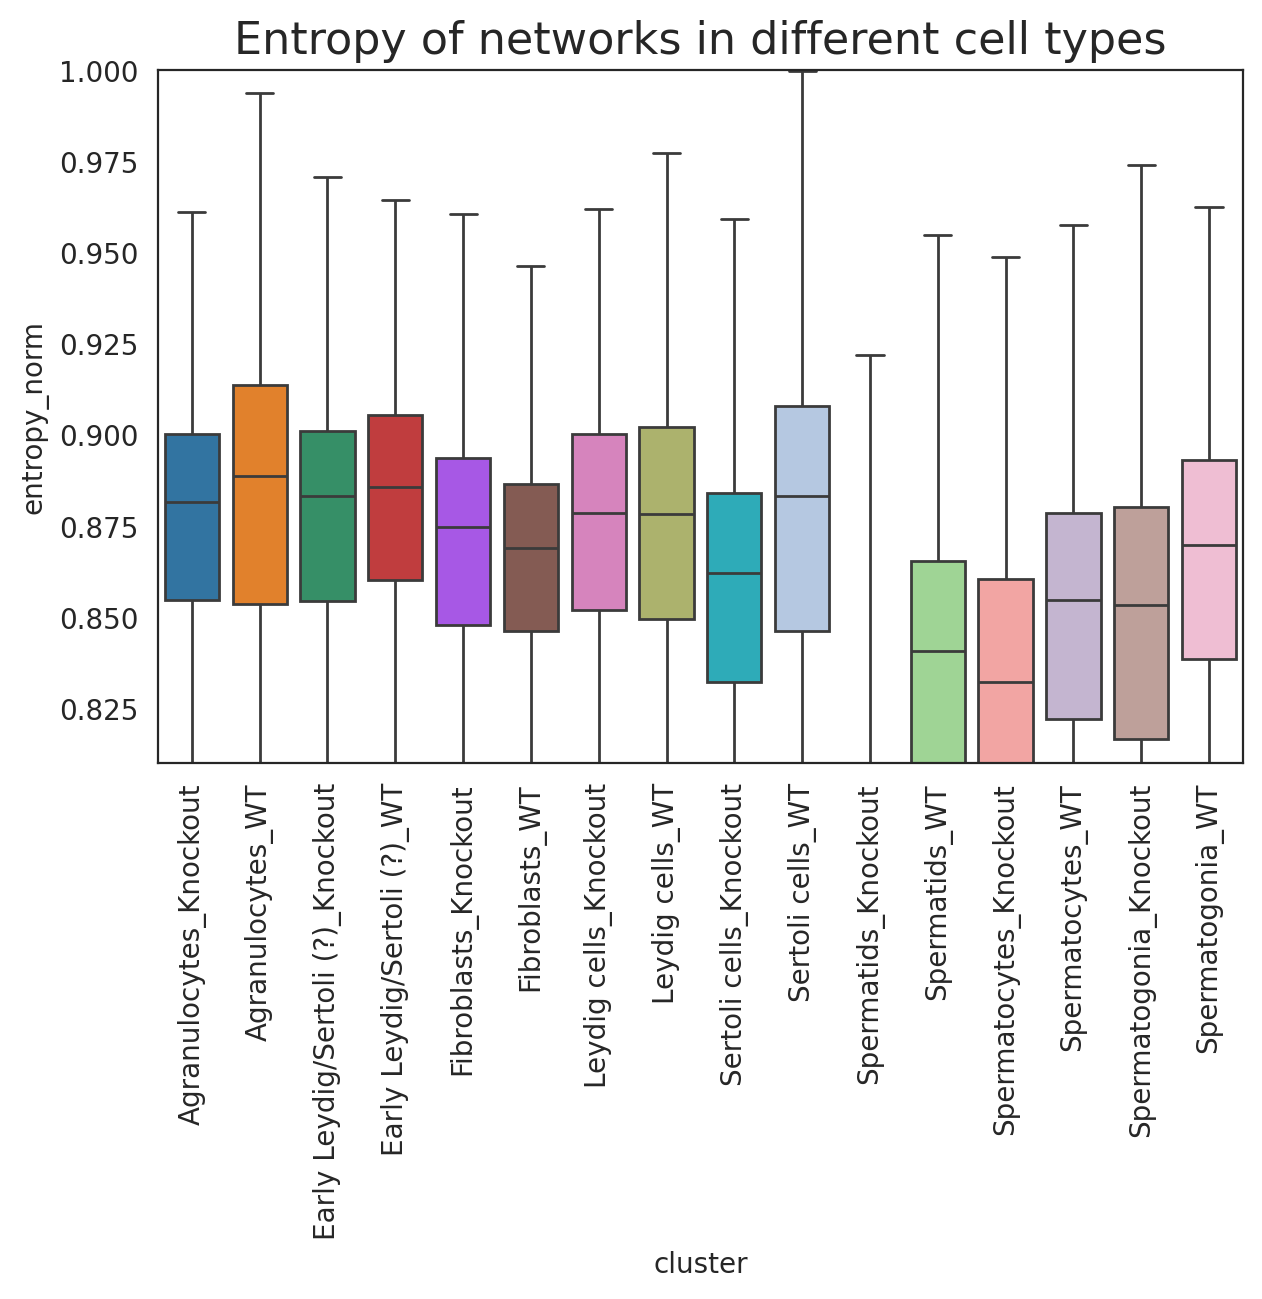

In [84]:
plt.title('Entropy of networks in different cell types', fontsize=16)
links.plot_network_entropy_distributions()

In [114]:
def func(subset):
    return ", ".join(subset["target"].values)

#links.filtered_links['Leydig cells_Knockout'].groupby(by="source").apply(lambda x: func(x)).reset_index()
#links.filtered_links['Leydig cells_WT'].groupby(by="source").apply(lambda x: func(x)).reset_index()

In [97]:
#переформировали таблички в формат TF | TF targets и сохранили

wt_TF_targets = links.filtered_links['Leydig cells_WT'].groupby(by="source").apply(lambda x: func(x)).reset_index()
wt_TF_targets.to_csv('Leydig_cells_WT_celloracle_TFtargets.csv', index=False)

ko_TF_targets = links.filtered_links['Leydig cells_Knockout'].groupby(by="source").apply(lambda x: func(x)).reset_index()
ko_TF_targets.to_csv('Leydig_cells_Knockout_celloracle_TFtargets.csv', index=False)

In [101]:
print(', '.join(wt_TF_targets[wt_TF_targets['source'].isin(['Rhox13', 'Fos', 'JunB'])][0]))

print(', '.join(ko_TF_targets[ko_TF_targets['source'].isin(['Rhox13', 'Fos', 'JunB'])][0]))

#Коллеги выбрали эти 3 TF, только для Fos есть GRN

Defb19, Gpx3, Apoc1, Rps4x, Adh1, Cst3, Gsn, Smcp, Rpl39, Star, Tmsb4x, Bgn, Prss35, Igfbp7, Clk1, Mbnl2, Igfbp6, Malat1, Rpl10a, Sparc, Osr2, Fdx1, Col6a1, Rpl36a, Marcks, S100a6, Vim, Clu, Nr2f2, Rarres2, Atxn7l3b, Pltp, Rpl10, Rbbp7, Efemp1, Apoe, Mgst1, Ahnak, Ebf1, Ubl4b, Kitl, Tmem176b, Glul, Fxyd1, Rpl14


In [96]:
base_GRN[base_GRN['gene_short_name'].isin(['Rhox13', 'Fos', 'JunB'])]

#Тут я проверяла, есть ли пути не для Fos

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
17984  chr12_86610863_86612127             Fos            0.0         0.0   
17990  chr12_86620428_86621876             Fos            1.0         0.0   
18005  chr12_86691430_86692287             Fos            0.0         0.0   
18013  chr12_86714741_86716375             Fos            0.0         0.0   
18020  chr12_86808434_86810042             Fos            0.0         0.0   
18022  chr12_86813984_86816154             Fos            0.0         0.0   
91276   chrX_35474263_35474468          Rhox13            0.0         0.0   

       Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  \
17984         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
17990         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
18005         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
18013         1.0         0.0  1.0  0.0   0.0   0.0  ...     1.0   0.0   
18020         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
18022         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
91276         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   

       Znf816  Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
17984     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
17990     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
18005     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
18013     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
18020     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
18022     0.0    0.0      0.0      0.0      1.0      0.0      0.0     0.0  
91276     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[7 rows x 1095 columns]

In [115]:
#base_GRN[base_GRN.columns[base_GRN.columns.isin(['Rhox13', 'Fos', 'JunB'])]]